In [1]:
from paths import models_folder, metadata_folder

In [2]:
from pyobsbox import ObsBoxGenerator

In [3]:
import logging
import keras
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

In [4]:
logging.getLogger("pyobsbox").setLevel(logging.INFO)

# List models

In [5]:
list(models_folder.glob('model_*'))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_20756'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_1024'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_1'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_20608'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_time_dist_32_16_B1H_Inst_500'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_8_B1H_Inst_252'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_16_8_stride_4_B1H_Inst_253'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_stride_4_B1H_Inst'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_stride_4_B1H_Inst_jorg'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_8_strid

In [6]:
model_path = models_folder / "model_conv_32_16_8_stride_4_B1H_Inst_center_scale_1000_seed_42"

In [7]:
list(model_path.glob('*fetched*'))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_8_stride_4_B1H_Inst_center_scale_1000_seed_42/validation_fetched.npy'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_8_stride_4_B1H_Inst_center_scale_1000_seed_42/train_fetched.npy')]

# Load model and associated generators

In [8]:
model = keras.models.load_model(model_path)
model.summary()
model_metadata = json.load((model_path / "metadata.json").open('r'))
data_metadata_path = model_metadata["generator"]["metadata_path"]

# load the data metadata
data_metadata_df = pd.read_hdf(data_metadata_path)

# load the indices of the data seen by the model
train_seen_indices = np.load(model_path / "train_fetched.npy")
validation_seen_indices = np.load(model_path / "validation_fetched.npy")

# train/validation split
# train_split_indices = np.load(model_path / "train_split_indices.npy")
# validation_split_indices = np.load(model_path / "validation_split_indices.npy")

# load the data seen by the model
train_metadata = data_metadata_df.iloc[train_seen_indices]
validation_metadata = data_metadata_df.iloc[validation_seen_indices]

# the training loss history
hist = model_metadata["history"]

# remove shuffling
model_metadata["generator"]["shuffle"] = True  # True because I don't have the seen values indices
# create the generators
train_generator = ObsBoxGenerator(train_metadata,
                                  **model_metadata["generator"])
validation_generator = ObsBoxGenerator(validation_metadata,
                                       **model_metadata["generator"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 512, 32)           256       
_________________________________________________________________
dropout (Dropout)            (None, 512, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 16)           3600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 8)             904       
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 128, 8)            456       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 8)            0

Feb/23 12:54:39 pyobsbox.generator INFO: metadata_path: /afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B1H_Inst_34994.h5
Feb/23 12:54:39 pyobsbox.generator INFO: shuffle: True
Feb/23 12:54:39 pyobsbox.generator INFO: seed: 42
Feb/23 12:54:39 pyobsbox.generator INFO: batch_size: 8192
Feb/23 12:54:39 pyobsbox.generator INFO: sequence_length: 2048
Feb/23 12:54:39 pyobsbox.generator INFO: n_bunches: 256
Feb/23 12:54:39 pyobsbox.generator INFO: __len__: 1038
Feb/23 12:54:39 pyobsbox.generator INFO: fetched_log_folder: None
Feb/23 12:54:39 pyobsbox.generator INFO: fetched_log_prefix: 
Feb/23 12:54:39 pyobsbox.generator INFO: normalization: center_scale
Feb/23 12:54:39 pyobsbox.generator INFO: normalization_pre_split: False
Feb/23 12:54:39 pyobsbox.generator INFO: normalization_kwargs: {'scale_factor': 1000}
Feb/23 12:54:39 pyobsbox.generator INFO: metadata_path: /afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B1H_Inst_34994.h5
Feb/23 12:54:39 pyobsbox

In [9]:
print(train_metadata.shape)
train_metadata.head()

(265728, 11)


type  fill  beam plane  q           date_time  \
7245997  Inst  6919     1     h  7 2018-07-13 18:25:14   
6889270  Inst  7453     1     h  7 2018-11-18 06:39:21   
1617712  Inst  6663     1     h  7 2018-05-10 15:13:15   
6141909  Inst  6953     1     h  7 2018-07-21 06:32:07   
593993   Inst  6245     1     h  7 2017-09-26 15:54:15   

                                                      file  n_bunches  \
7245997  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6919/...       2556   
6889270  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7453/...        480   
1617712  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6663/...       2556   
6141909  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6953/...       2556   
593993   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6245/...       1916   

         bunch_index  bunch_number  ts_length  
7245997        256.0         162.0      65536  
6889270        697.0         128.0      65536  
1617712       1775.0        1301.0      65536  
6141909        214.0         127.0      65536  
593993        2907.0        1600.0      65536

In [10]:
print(validation_metadata.shape)
validation_metadata.head()

(3840, 11)


type  fill  beam plane  q           date_time  \
6235319  Inst  7489     1     h  7 2018-12-01 18:41:14   
972384   Inst  7485     1     h  7 2018-11-29 19:47:10   
4051785  Inst  6759     1     h  7 2018-06-04 23:39:37   
4000154  Inst  7442     1     h  7 2018-11-13 20:16:16   
3610681  Inst  6275     1     h  7 2017-10-06 08:56:54   

                                                      file  n_bunches  \
6235319  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7489/...        733   
972384   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7485/...        271   
4051785  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6759/...        396   
4000154  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7442/...        632   
3610681  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6275/...       1868   

         bunch_index  bunch_number  ts_length  
6235319       2663.0         563.0      65536  
972384        1072.0         226.0      65536  
4051785        100.0          32.0      65536  
4000154       1849.0         336.0      65536  
3610681        654.0         351.0      65536

# Loss functions

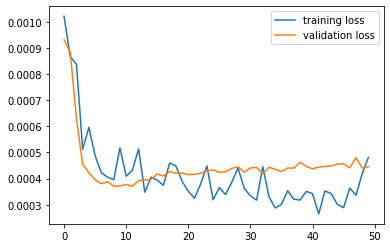

In [11]:
plt.plot(hist['loss'], label='training loss')
plt.plot(hist['val_loss'], label='validation loss')
plt.legend()

# Datasets

Load the first few batches

In [12]:
train_dataset = np.vstack([train_generator[i][0] for i in tqdm(range(50))])
train_dataset.shape

(409600, 2048, 1)

In [13]:
validation_dataset = np.vstack([validation_generator[i][0] for i in tqdm(range(5))])
validation_dataset.shape

(40960, 2048, 1)

# Predictions

In [14]:
train_pred = model.predict(train_dataset, verbose=1, batch_size=train_generator.batch_size)
train_pred.shape

50/50 [==============================] - 56s 1s/step


(409600, 2048, 1)

In [15]:
validation_pred = model.predict(validation_dataset, verbose=1, batch_size=validation_generator.batch_size)
validation_pred.shape

5/5 [==============================] - 5s 993ms/step


(40960, 2048, 1)

In [16]:
MAE_train = abs(train_pred - train_dataset).mean(axis=1).squeeze()
MAE_train.shape

(409600,)

In [17]:
MAE_validation = abs(validation_pred - validation_dataset).mean(axis=1).squeeze()
MAE_validation.shape

(40960,)

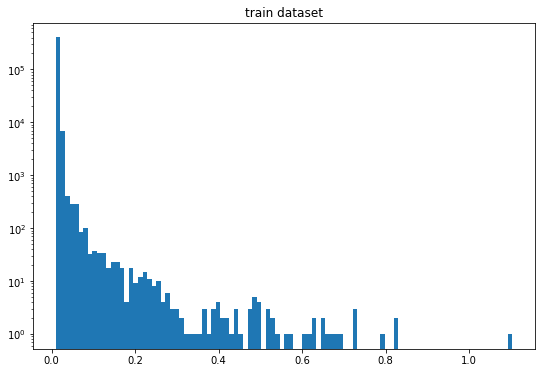

In [38]:
plt.figure(figsize=(9, 6))
n, bins, _ = plt.hist(MAE_train, bins=100)
plt.title("train dataset")
plt.yscale('log')

rough peak

In [19]:
hist_peak_train = bins[n.argmax()]
hist_peak_train

0.010028678846424555

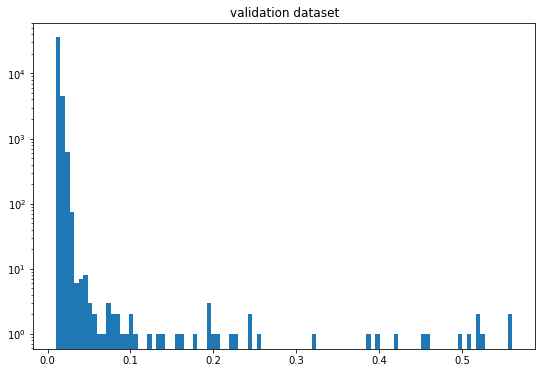

In [20]:
plt.figure(figsize=(9, 6))
n, bins, _ = plt.hist(MAE_validation, bins=100)
plt.title("validation dataset")
plt.yscale('log')

In [21]:
hist_peak_validation = bins[n.argmax()]
hist_peak_validation

0.010028678846424555

In [22]:
max_MAE_indices = np.argsort(MAE_train)[::-1]

In [23]:
max_MAE_indices

array([206216, 190124,  29305, ..., 190577, 364081, 271993])

In [24]:
def plot_true_pred(true_signal, pred_signal):
    fig, axes = plt.subplots(2, figsize=(16, 6))
    axes[0].plot(true_signal)
    axes[0].plot(pred_signal)

    axes[1].plot(np.abs(np.diff(true_signal)))
    axes[1].plot(np.abs(np.diff(pred_signal)))
    return fig, axes

index:  206216
MAE:  1.103831116904872
n_bunches       2556
bunch_index     3290
bunch_number    2447
Name: 10458146, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6919/instability_data/06919_Inst_B1H_Q7_20180713_15h48m14s.h5


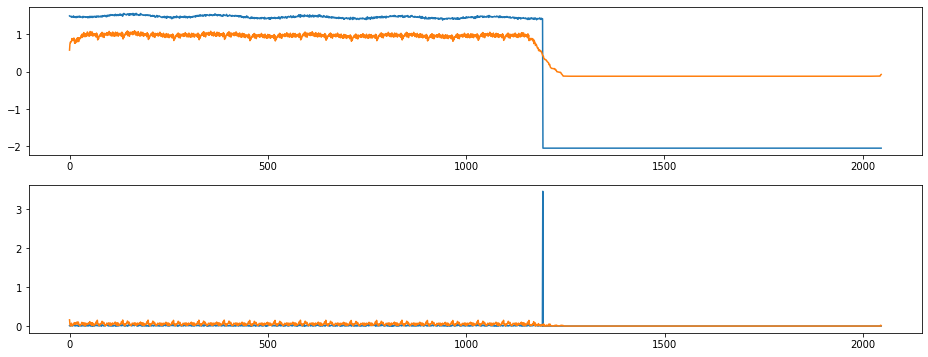

In [25]:
anomalous = 0
anomalous_index = max_MAE_indices[anomalous]

print('index: ', anomalous_index)
print("MAE: ", MAE_train[anomalous_index])
# I'm not sure this row is correct
metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
print(metadata_row['file'])

true_signal = train_dataset[anomalous_index].squeeze()
pred_signal = train_pred[anomalous_index].squeeze()

plot_true_pred(true_signal, pred_signal);

# Top rightmost signals

index:  206216
MAE:  1.103831116904872
n_bunches       2556
bunch_index     3290
bunch_number    2447
Name: 10458146, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6919/instability_data/06919_Inst_B1H_Q7_20180713_15h48m14s.h5


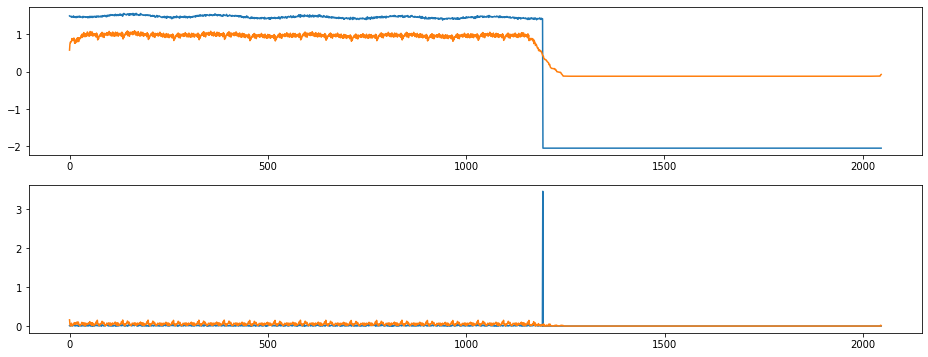

index:  190124
MAE:  0.8267367942707557
n_bunches       540
bunch_index     604
bunch_number    274
Name: 8385364, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7356/instability_data/07356_Inst_B1H_Q7_20181025_23h14m10s.h5


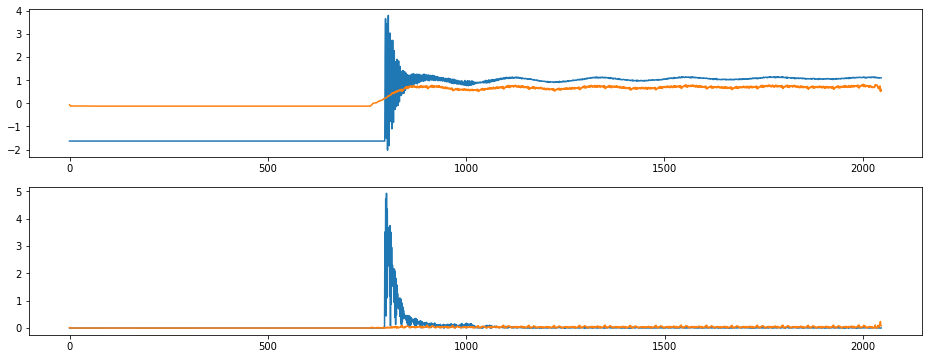

index:  29305
MAE:  0.8222281838854322
n_bunches        180
bunch_index     1653
bunch_number     101
Name: 6135380, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7361/instability_data/07361_Inst_B1H_Q7_20181026_15h02m25s.h5


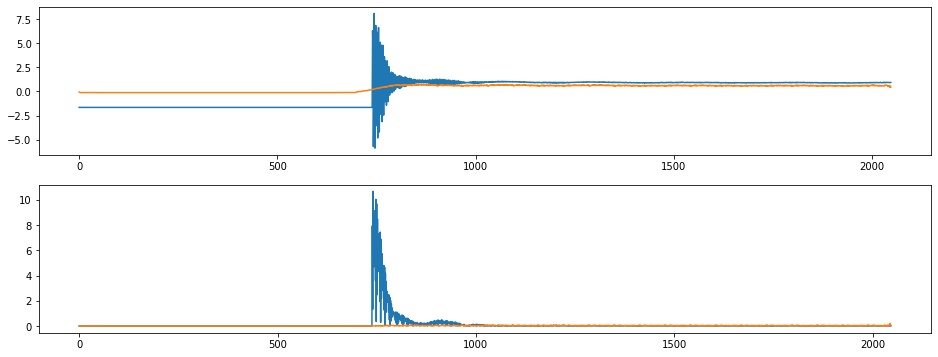

index:  365814
MAE:  0.791390090326662
n_bunches       265
bunch_index     478
bunch_number    144
Name: 6425847, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6618/instability_data/06618_Inst_B1H_Q7_20180428_03h54m13s.h5


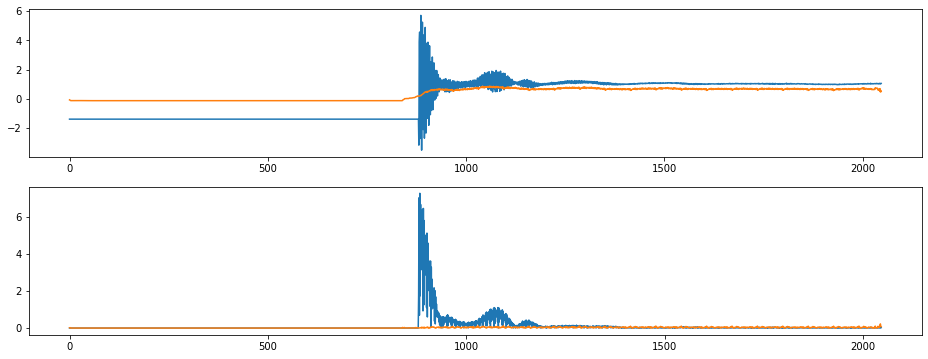

index:  78795
MAE:  0.7289054983651841
n_bunches       1004
bunch_index      966
bunch_number     519
Name: 4869340, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6341/instability_data/06341_Inst_B1H_Q7_20171028_00h07m49s.h5


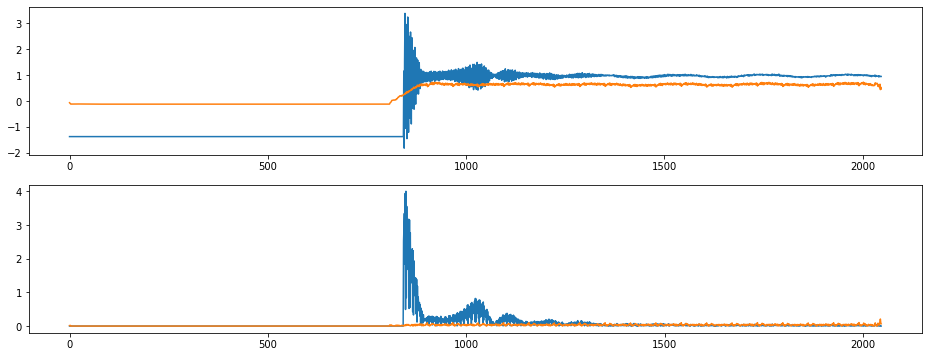

index:  149206
MAE:  0.7281070379986369
n_bunches       1887
bunch_index     1153
bunch_number     647
Name: 7696243, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6629/instability_data/06629_Inst_B1H_Q7_20180501_12h24m14s.h5


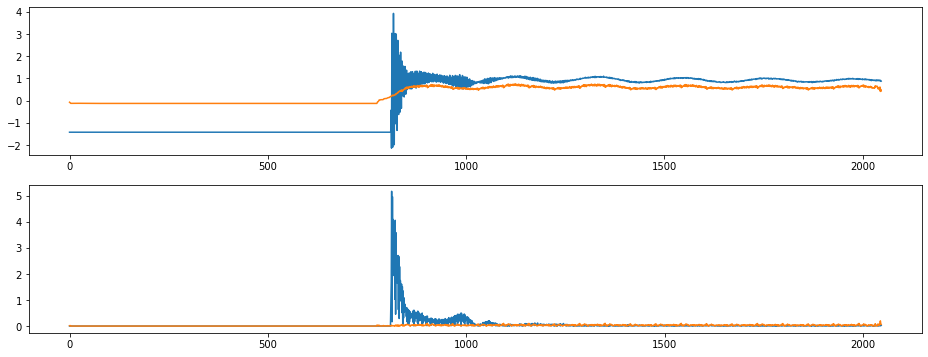

index:  406795
MAE:  0.7214782387059924
n_bunches       1452
bunch_index     3068
bunch_number    1307
Name: 3089590, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6890/instability_data/06890_Inst_B1H_Q7_20180705_22h44m14s.h5


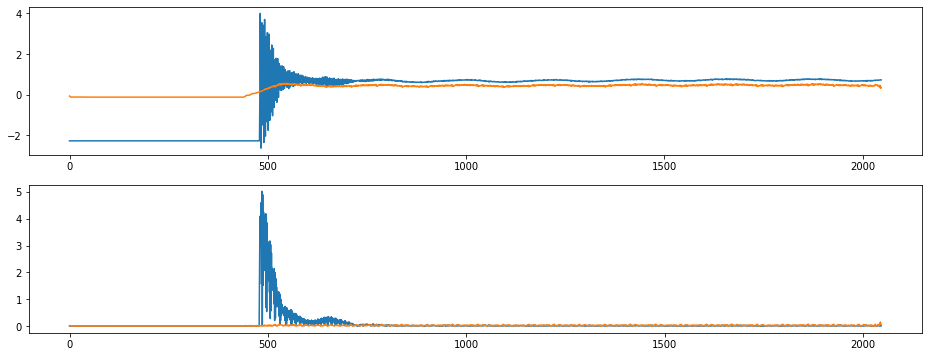

index:  326153
MAE:  0.6911518848472659
n_bunches       428
bunch_index     137
bunch_number     57
Name: 7519487, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6442/instability_data/06442_Inst_B1H_Q7_20171201_00h02m07s.h5


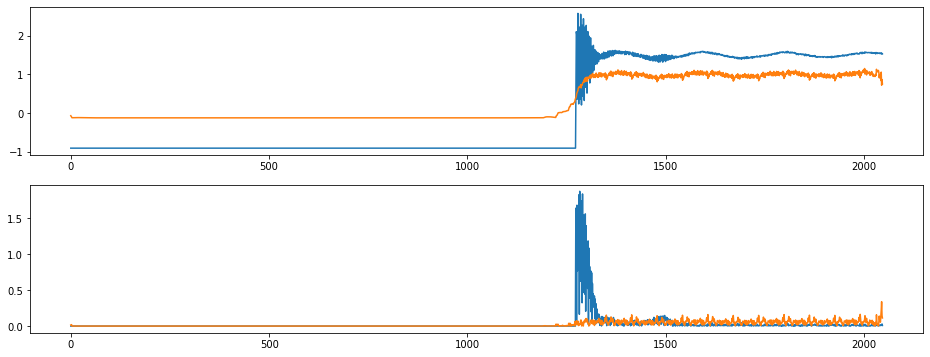

index:  350979
MAE:  0.6790853122018424
n_bunches       361
bunch_index     203
bunch_number     39
Name: 9131435, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7036/instability_data/07036_Inst_B1H_Q7_20180807_20h32m53s.h5


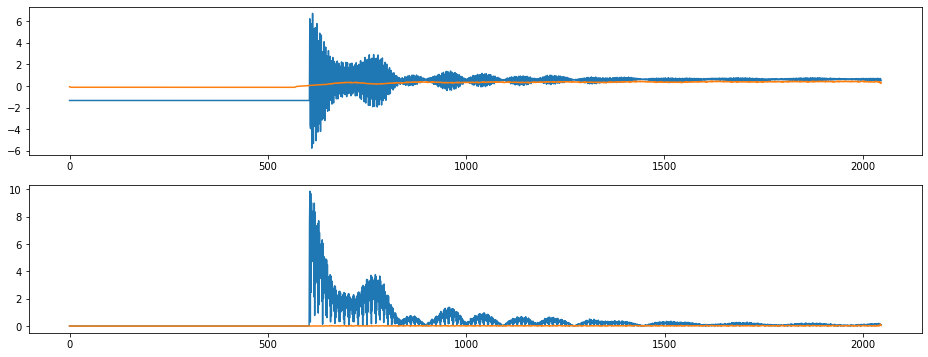

index:  150002
MAE:  0.6714419514849932
n_bunches       1868
bunch_index     1801
bunch_number     963
Name: 9138831, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6364/instability_data/06364_Inst_B1H_Q7_20171106_03h13m17s.h5


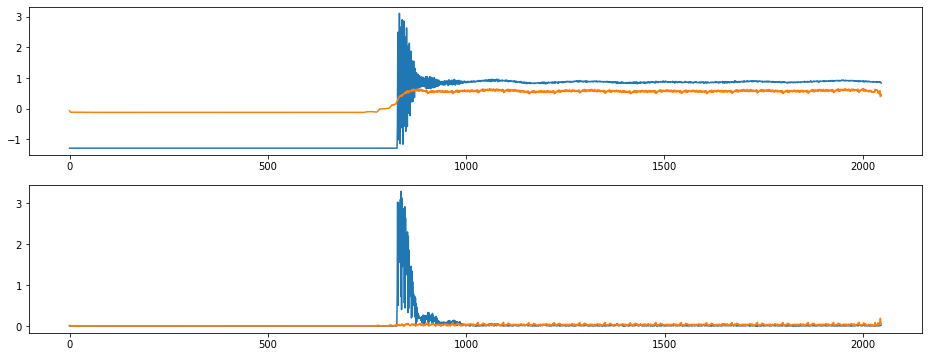

In [26]:
for i in range(10):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# Top leftmost signals

index:  271993
MAE:  0.010028678846424555
n_bunches        670
bunch_index     2088
bunch_number     440
Name: 9236921, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7466/instability_data/07466_Inst_B1H_Q7_20181123_02h16m14s.h5


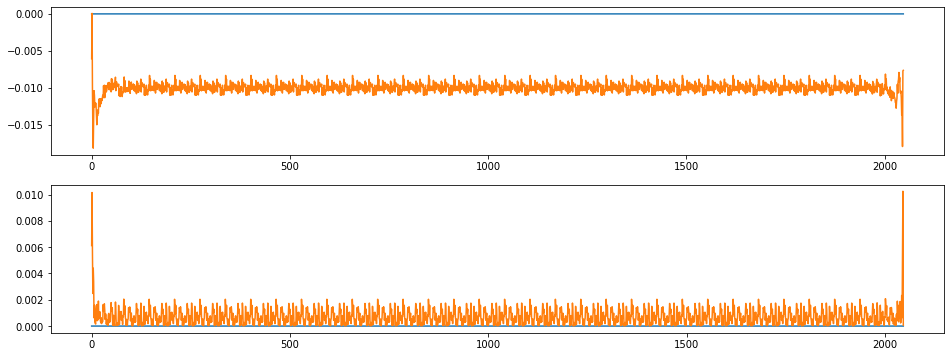

index:  364081
MAE:  0.010028678846424555
n_bunches       252
bunch_index     150
bunch_number     94
Name: 3547425, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7252/instability_data/07252_Inst_B1H_Q7_20181003_02h04m47s.h5


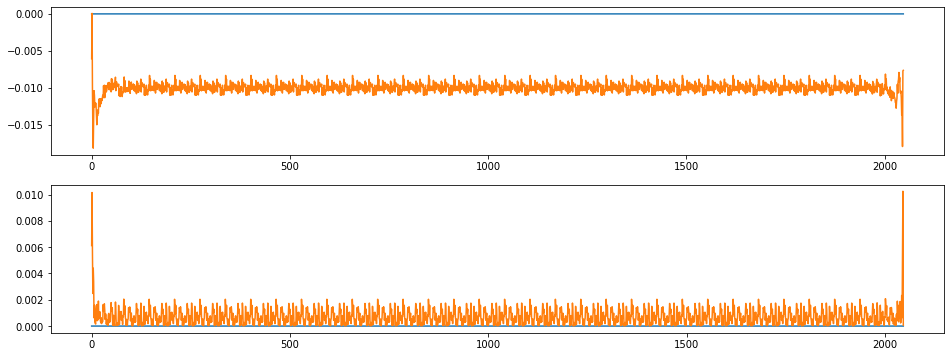

index:  190577
MAE:  0.010028678846424555
n_bunches       1452
bunch_index     2288
bunch_number     968
Name: 10107421, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6891/instability_data/06891_Inst_B1H_Q7_20180706_16h53m15s.h5


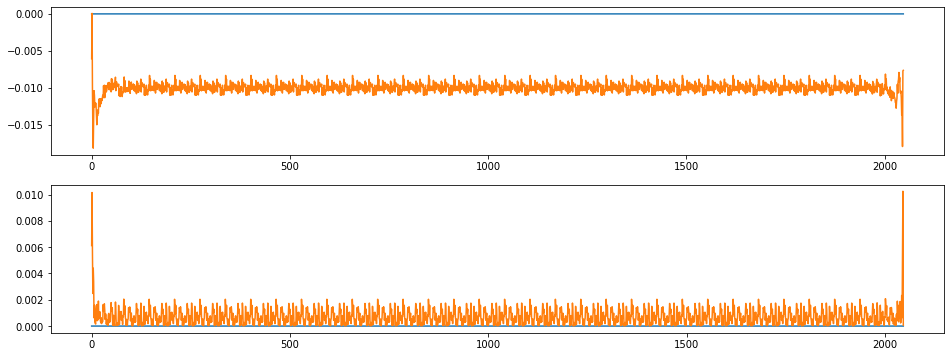

index:  265200
MAE:  0.010028678846424555
n_bunches       1068
bunch_index      648
bunch_number     464
Name: 6413609, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7080/instability_data/07080_Inst_B1H_Q7_20180823_22h07m32s.h5


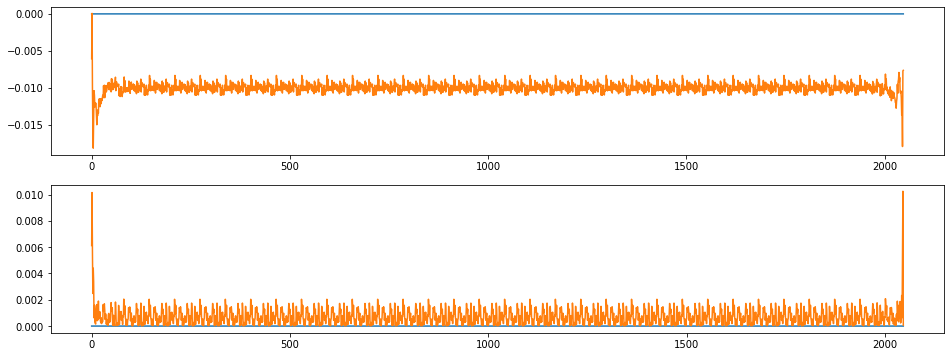

index:  349262
MAE:  0.010028678846424555
n_bunches       1212
bunch_index      824
bunch_number     591
Name: 8176353, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6940/instability_data/06940_Inst_B1H_Q7_20180718_05h01m14s.h5


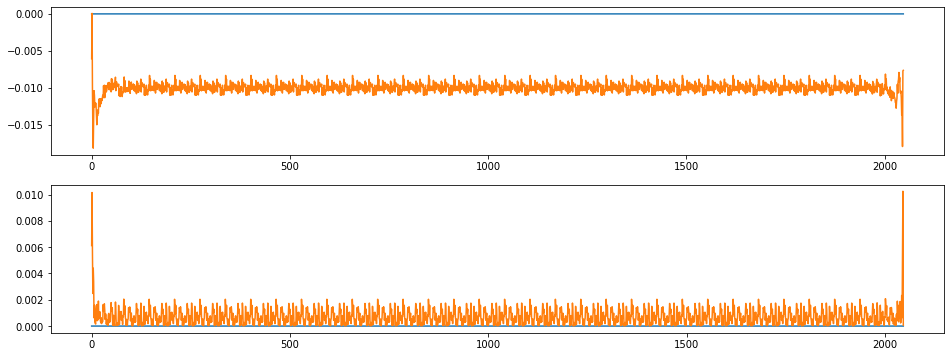

index:  47600
MAE:  0.010028678846424555
n_bunches       670
bunch_index     730
bunch_number    155
Name: 9822147, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7466/instability_data/07466_Inst_B1H_Q7_20181123_00h23m14s.h5


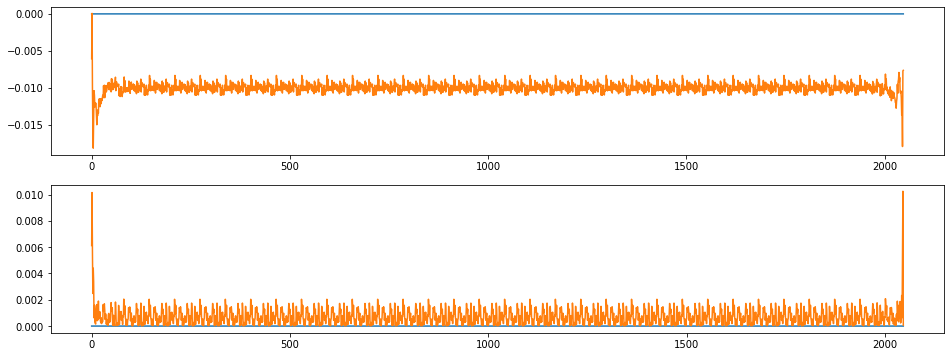

index:  135540
MAE:  0.010028678846424555
n_bunches        648
bunch_index     2602
bunch_number     485
Name: 8484554, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7448/instability_data/07448_Inst_B1H_Q7_20181116_08h29m15s.h5


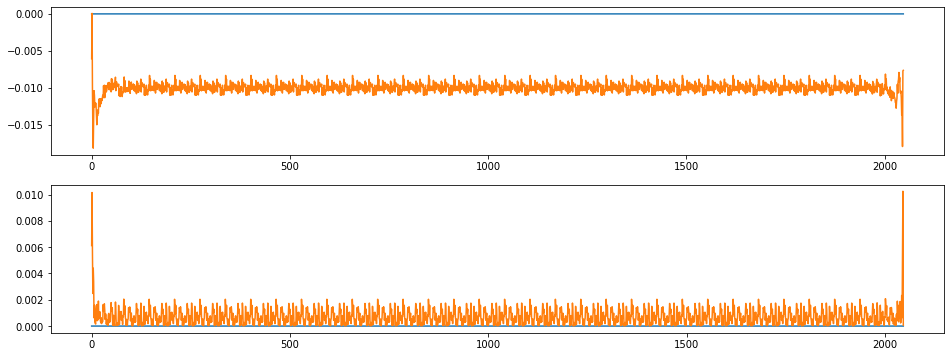

index:  65764
MAE:  0.010028678846424555
n_bunches       1868
bunch_index     1540
bunch_number     835
Name: 8366492, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6362/instability_data/06362_Inst_B1H_Q7_20171105_13h51m14s.h5


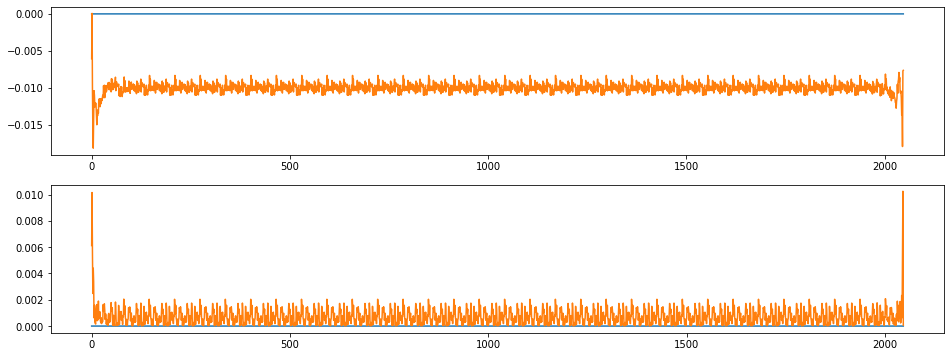

index:  290497
MAE:  0.010028678846424555
n_bunches       2556
bunch_index     1353
bunch_number     992
Name: 4452849, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7037/instability_data/07037_Inst_B1H_Q7_20180808_03h44m14s.h5


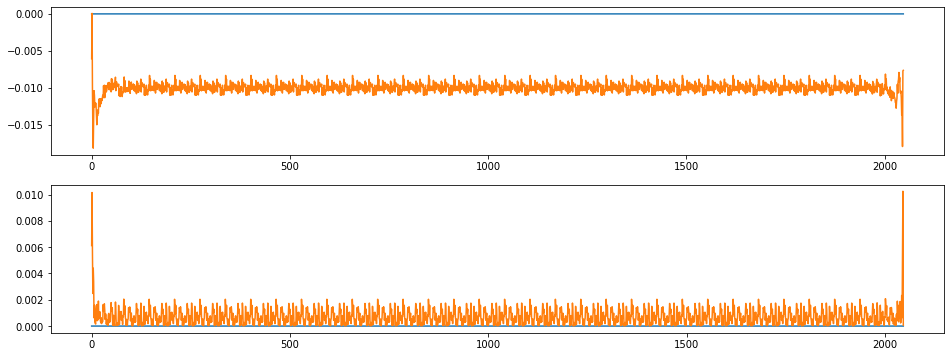

index:  42696
MAE:  0.010028678846424555
n_bunches       733
bunch_index     718
bunch_number    152
Name: 7545570, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7487/instability_data/07487_Inst_B1H_Q7_20181201_02h04m15s.h5


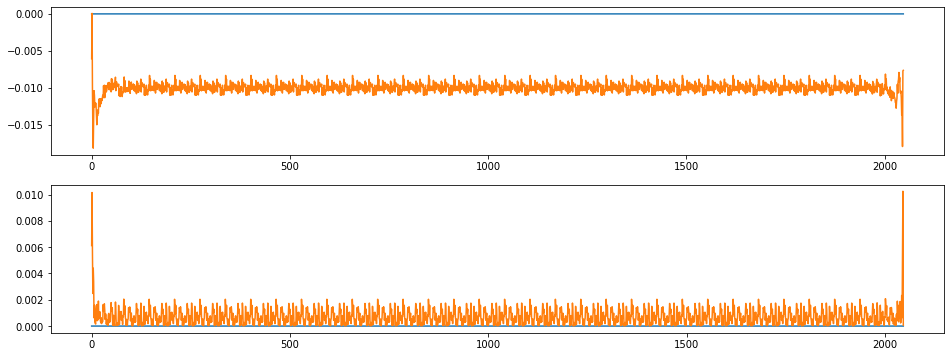

In [27]:
for i in range(1, 11):
    left_most = -i
    left_most_index = max_MAE_indices[left_most]

    print('index: ', left_most_index)
    print("MAE: ", MAE_train[left_most_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[left_most_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])


    true_signal = train_dataset[left_most_index].squeeze()
    pred_signal = train_pred[left_most_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# Signals around the peak

In [28]:
around_peak_indices = np.argsort(np.abs(MAE_train - hist_peak_train))

index:  271993
MAE:  0.010028678846424555
n_bunches        670
bunch_index     2088
bunch_number     440
Name: 9236921, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7466/instability_data/07466_Inst_B1H_Q7_20181123_02h16m14s.h5


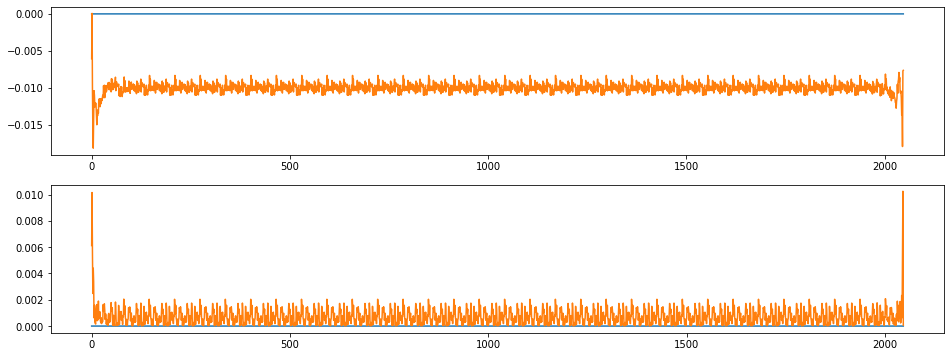

index:  364081
MAE:  0.010028678846424555
n_bunches       252
bunch_index     150
bunch_number     94
Name: 3547425, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7252/instability_data/07252_Inst_B1H_Q7_20181003_02h04m47s.h5


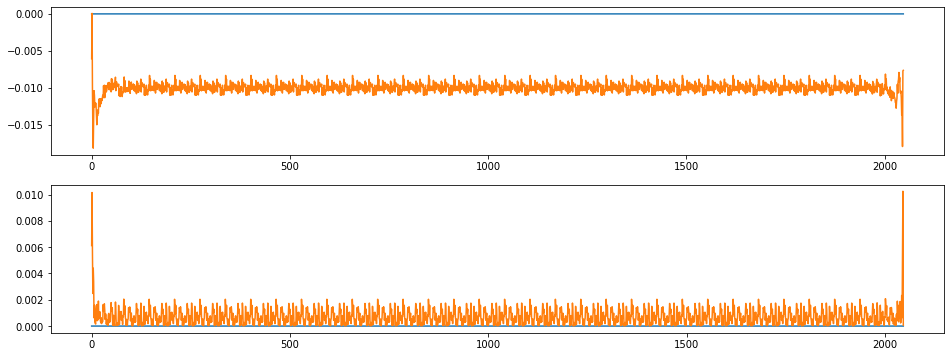

index:  190577
MAE:  0.010028678846424555
n_bunches       1452
bunch_index     2288
bunch_number     968
Name: 10107421, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6891/instability_data/06891_Inst_B1H_Q7_20180706_16h53m15s.h5


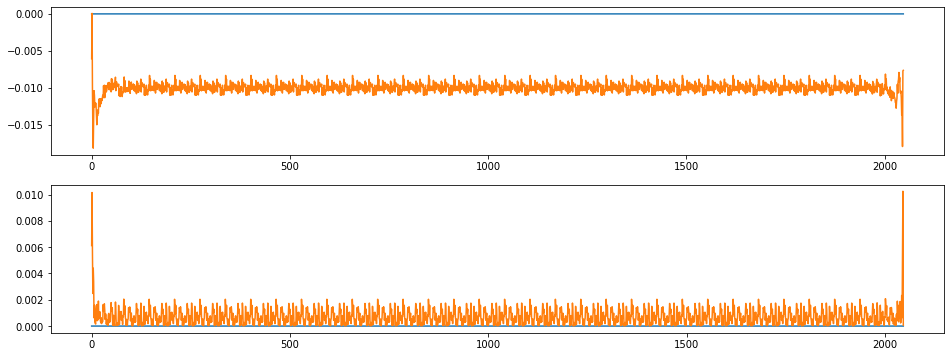

index:  265200
MAE:  0.010028678846424555
n_bunches       1068
bunch_index      648
bunch_number     464
Name: 6413609, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7080/instability_data/07080_Inst_B1H_Q7_20180823_22h07m32s.h5


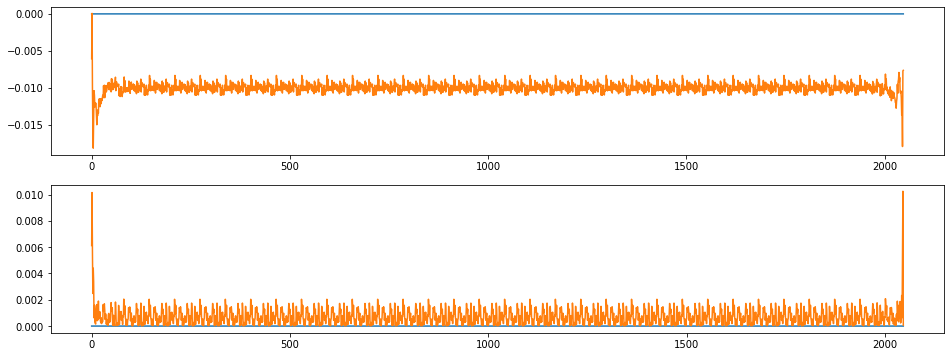

index:  349262
MAE:  0.010028678846424555
n_bunches       1212
bunch_index      824
bunch_number     591
Name: 8176353, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6940/instability_data/06940_Inst_B1H_Q7_20180718_05h01m14s.h5


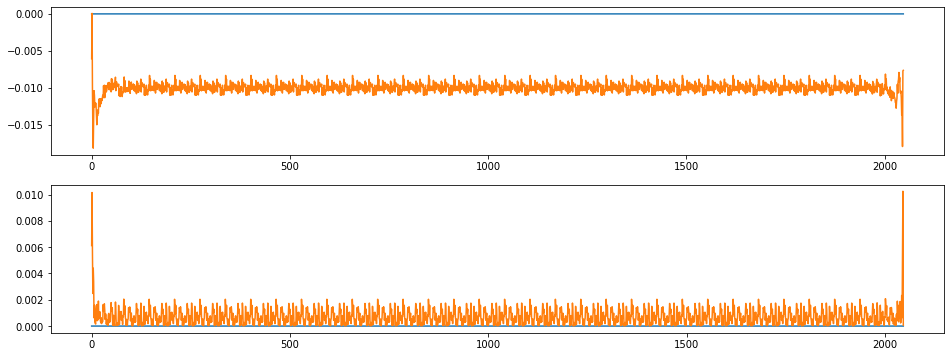

index:  47600
MAE:  0.010028678846424555
n_bunches       670
bunch_index     730
bunch_number    155
Name: 9822147, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7466/instability_data/07466_Inst_B1H_Q7_20181123_00h23m14s.h5


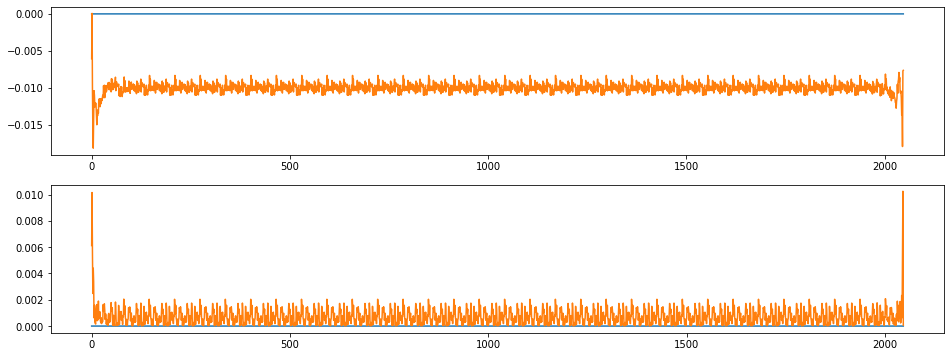

index:  135540
MAE:  0.010028678846424555
n_bunches        648
bunch_index     2602
bunch_number     485
Name: 8484554, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7448/instability_data/07448_Inst_B1H_Q7_20181116_08h29m15s.h5


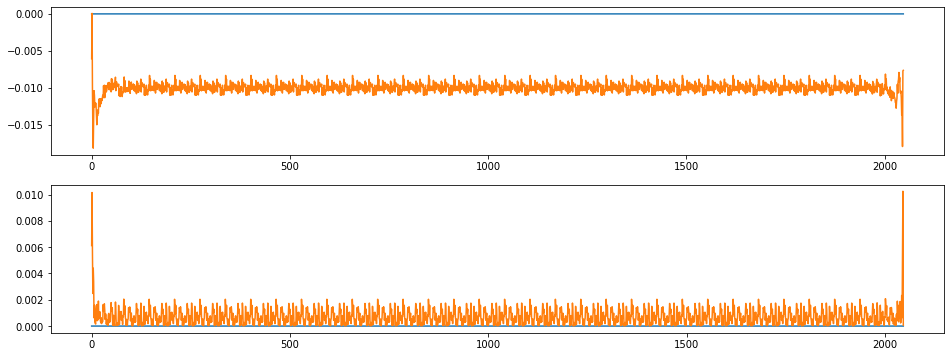

index:  65764
MAE:  0.010028678846424555
n_bunches       1868
bunch_index     1540
bunch_number     835
Name: 8366492, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6362/instability_data/06362_Inst_B1H_Q7_20171105_13h51m14s.h5


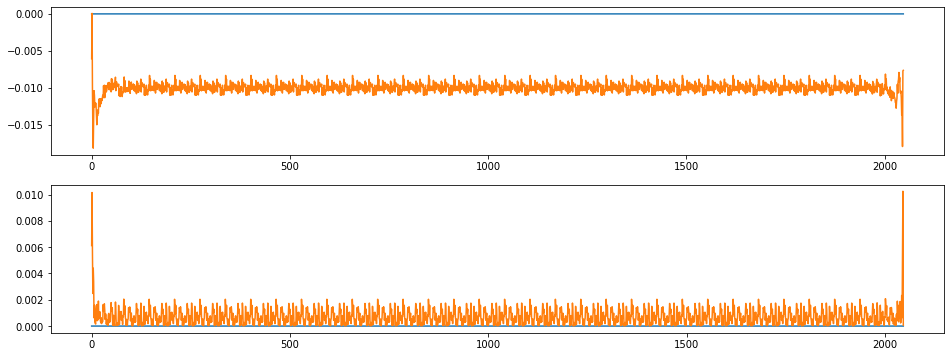

index:  290497
MAE:  0.010028678846424555
n_bunches       2556
bunch_index     1353
bunch_number     992
Name: 4452849, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7037/instability_data/07037_Inst_B1H_Q7_20180808_03h44m14s.h5


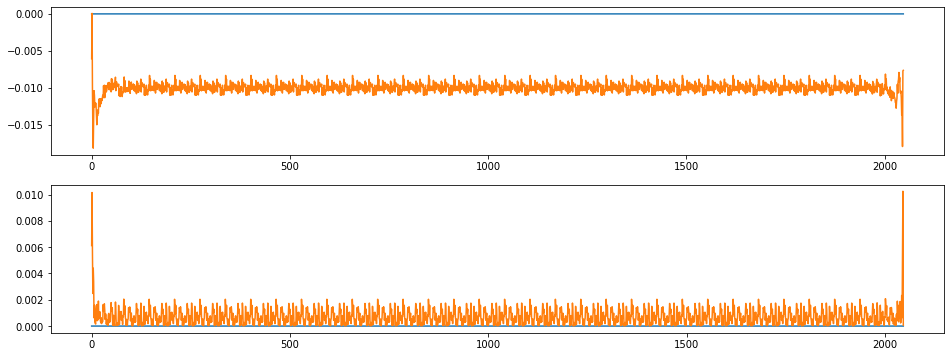

index:  42696
MAE:  0.010028678846424555
n_bunches       733
bunch_index     718
bunch_number    152
Name: 7545570, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7487/instability_data/07487_Inst_B1H_Q7_20181201_02h04m15s.h5


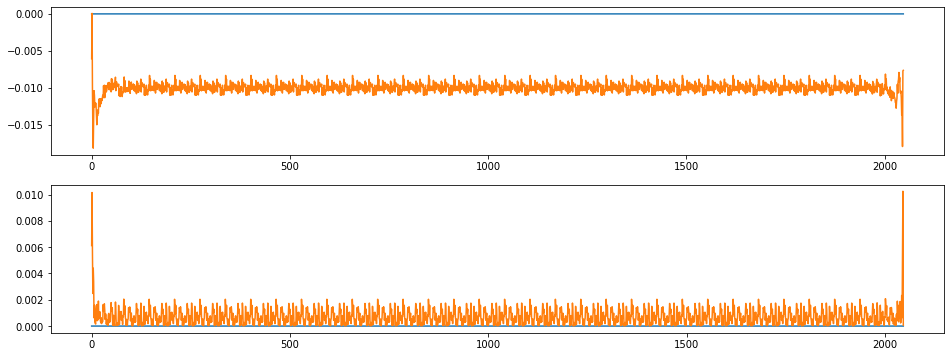

In [29]:
for i in range(10):
    around_peak_index = around_peak_indices[i]

    print('index: ', around_peak_index)
    print("MAE: ", MAE_train[around_peak_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[around_peak_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[around_peak_index].squeeze()
    pred_signal = train_pred[around_peak_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# around a point

In [30]:
around_point_indices = np.argsort(np.abs(MAE_train - 0.6))

index:  186405
MAE:  0.600752833067232
n_bunches       2556
bunch_index     2233
bunch_number    1638
Name: 6324133, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6654/instability_data/06654_Inst_B1H_Q7_20180508_01h11m13s.h5


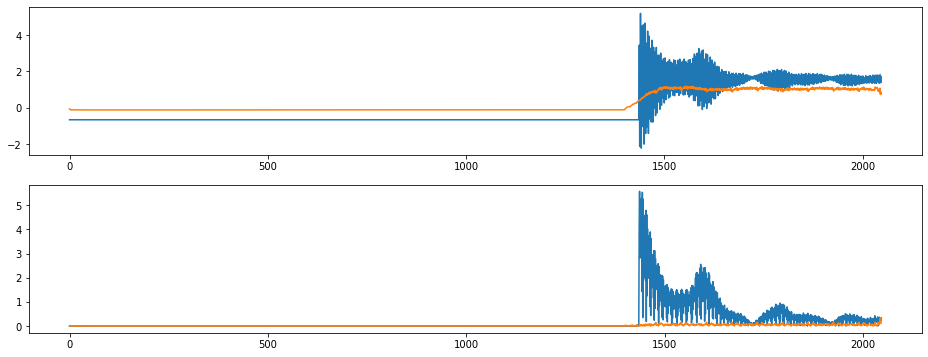

index:  44050
MAE:  0.6198713490020453
n_bunches       1887
bunch_index     2987
bunch_number    1648
Name: 10157846, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6693/instability_data/06693_Inst_B1H_Q7_20180517_06h44m13s.h5


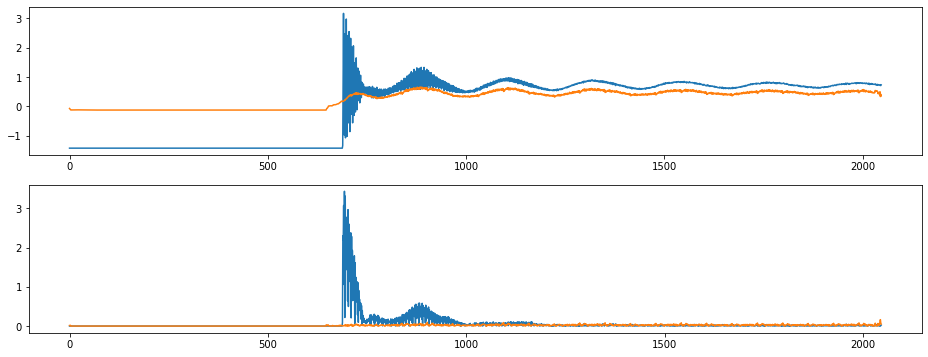

index:  331638
MAE:  0.6278571035732456
n_bunches        733
bunch_index     1903
bunch_number     400
Name: 8042049, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7487/instability_data/07487_Inst_B1H_Q7_20181201_01h12m15s.h5


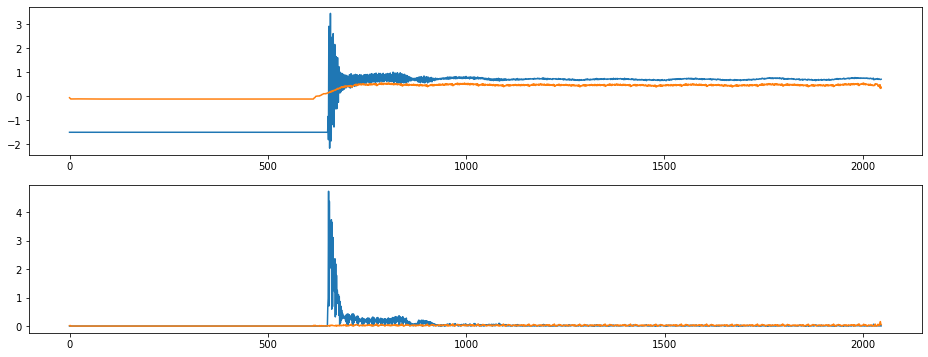

index:  214202
MAE:  0.6282899304895109
n_bunches       1227
bunch_index      530
bunch_number     249
Name: 1772365, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6690/instability_data/06690_Inst_B1H_Q7_20180516_09h14m14s.h5


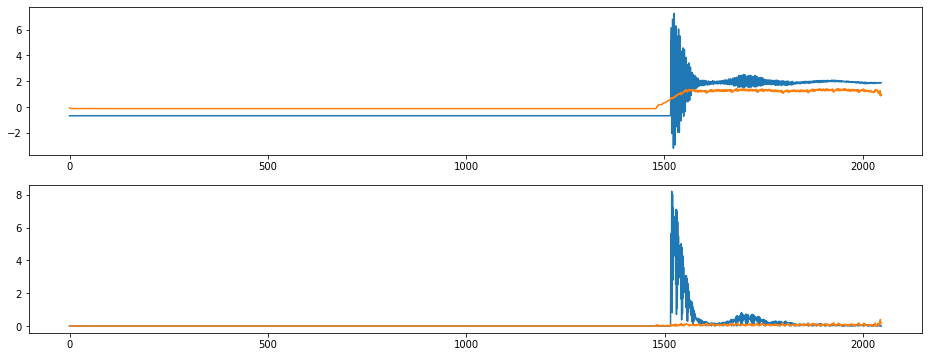

index:  344229
MAE:  0.5680500679035959
n_bunches       1452
bunch_index      548
bunch_number     221
Name: 3109432, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6890/instability_data/06890_Inst_B1H_Q7_20180705_14h55m15s.h5


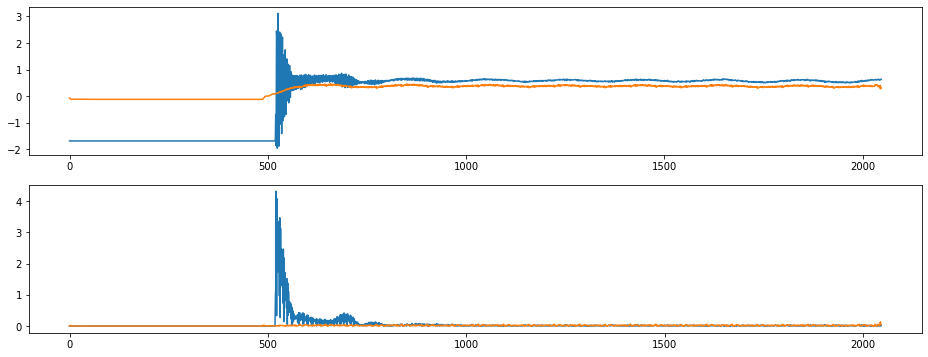

index:  237216
MAE:  0.5576742434503212
n_bunches        734
bunch_index     1022
bunch_number     204
Name: 9399237, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6881/instability_data/06881_Inst_B1H_Q7_20180703_07h01m49s.h5


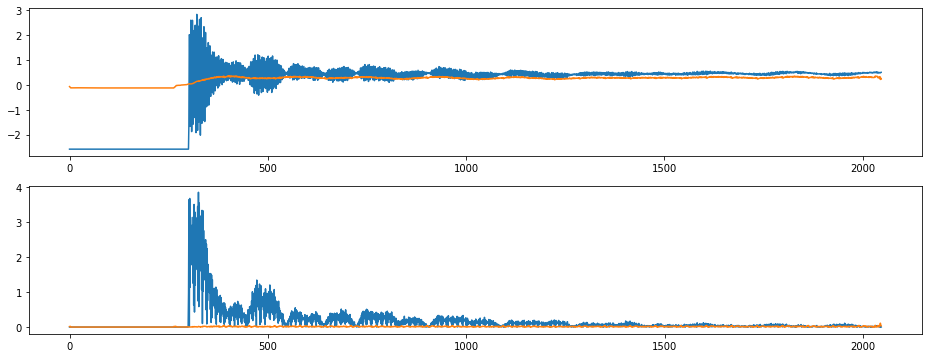

index:  199359
MAE:  0.6508316806511785
n_bunches       652
bunch_index     825
bunch_number    428
Name: 8681950, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6360/instability_data/06360_Inst_B1H_Q7_20171103_13h14m08s.h5


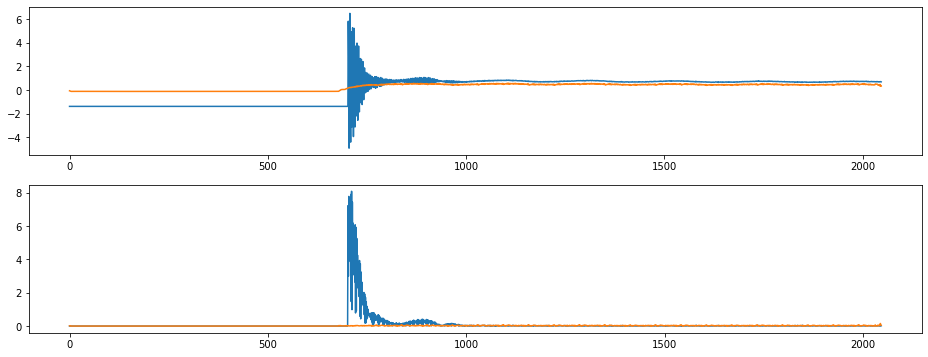

index:  113308
MAE:  0.652283001820493
n_bunches       2460
bunch_index      834
bunch_number     595
Name: 1559591, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6860/instability_data/06860_Inst_B1H_Q7_20180628_17h38m59s.h5


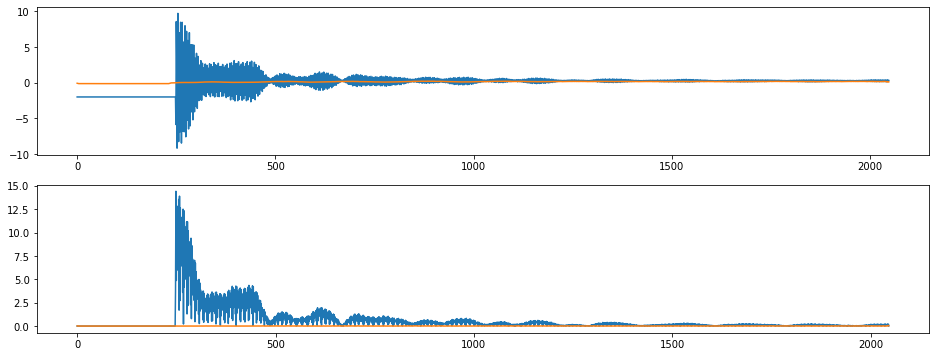

index:  126055
MAE:  0.5453832138654033
n_bunches       24
bunch_index     48
bunch_number    11
Name: 1312686, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6680/instability_data/06680_Inst_B1H_Q7_20180514_06h03m15s.h5


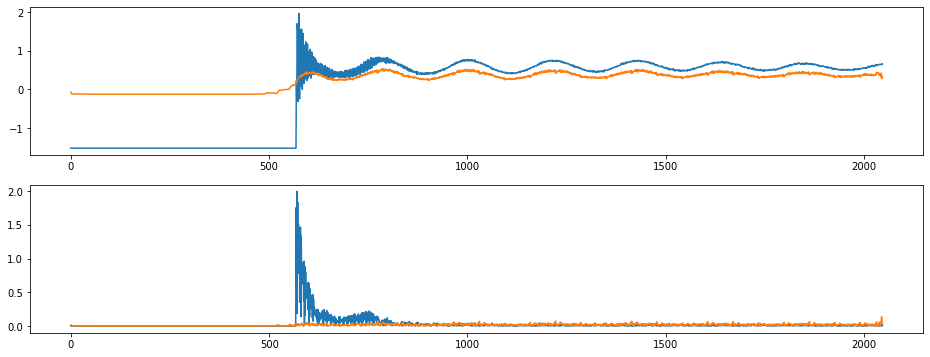

index:  103571
MAE:  0.662062803117413
n_bunches       924
bunch_index     272
bunch_number    178
Name: 10147119, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7033/instability_data/07033_Inst_B1H_Q7_20180807_03h59m19s.h5


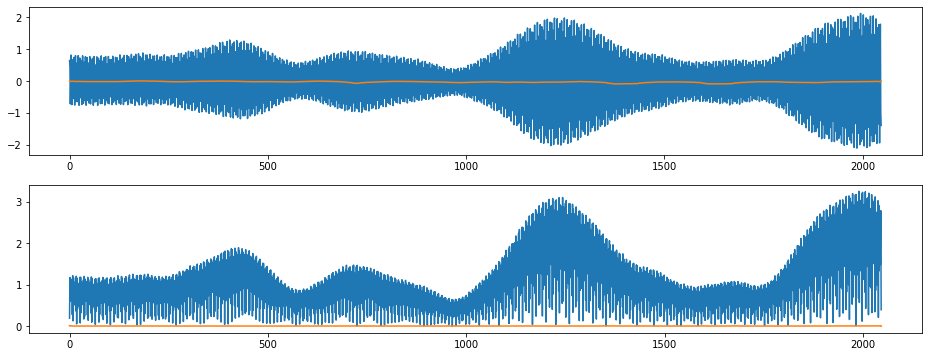

In [31]:
for i in range(10):
    around_point_index = around_point_indices[i]

    print('index: ', around_point_index)
    print("MAE: ", MAE_train[around_point_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[around_point_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[around_point_index].squeeze()
    pred_signal = train_pred[around_point_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# latent space encoding

In [32]:
import keras

In [33]:
encoding_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer('conv1d_2').output)

In [34]:
encoding_output = encoding_model(train_dataset[max_MAE_indices[-1]][None, :])
encoding_output.shape

TensorShape([1, 32, 8])

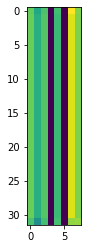

In [35]:
plt.imshow(np.array(encoding_output).squeeze())

# Latent space encoding of nominal signals

index:  271993
MAE:  0.010028678846424555
n_bunches        670
bunch_index     2088
bunch_number     440
Name: 9236921, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7466/instability_data/07466_Inst_B1H_Q7_20181123_02h16m14s.h5


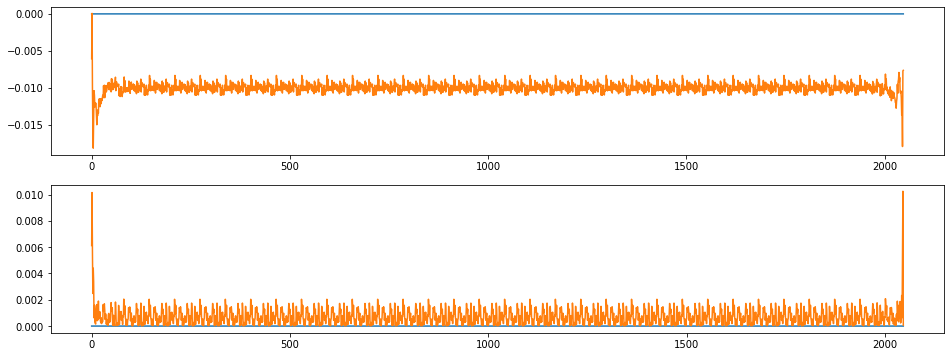

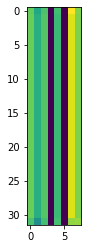

index:  364081
MAE:  0.010028678846424555
n_bunches       252
bunch_index     150
bunch_number     94
Name: 3547425, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7252/instability_data/07252_Inst_B1H_Q7_20181003_02h04m47s.h5


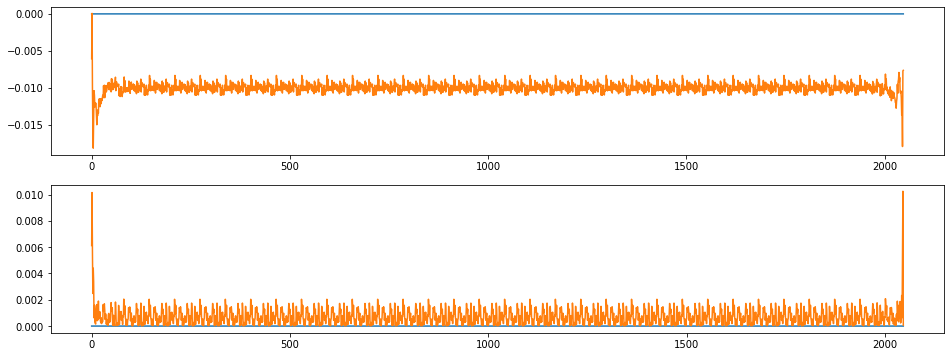

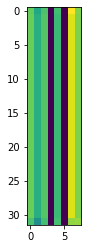

index:  190577
MAE:  0.010028678846424555
n_bunches       1452
bunch_index     2288
bunch_number     968
Name: 10107421, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6891/instability_data/06891_Inst_B1H_Q7_20180706_16h53m15s.h5


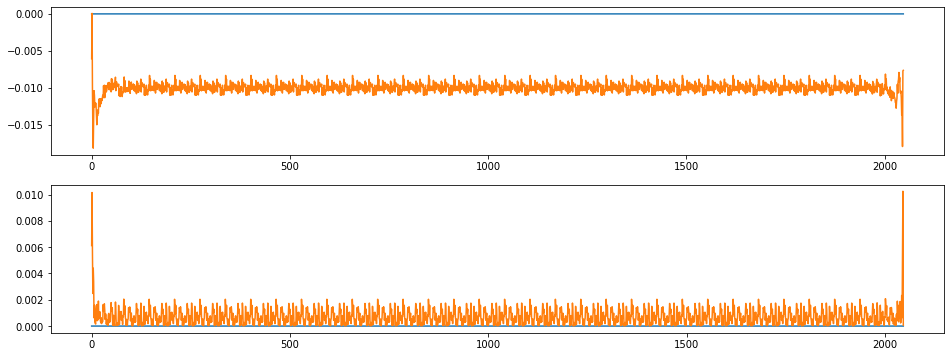

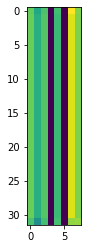

index:  265200
MAE:  0.010028678846424555
n_bunches       1068
bunch_index      648
bunch_number     464
Name: 6413609, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7080/instability_data/07080_Inst_B1H_Q7_20180823_22h07m32s.h5


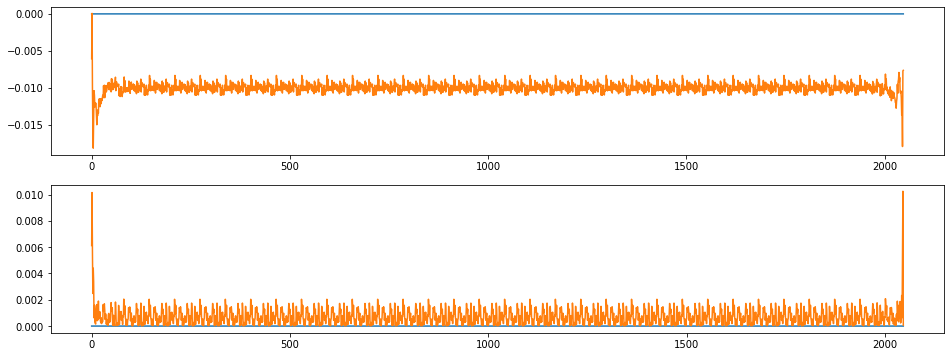

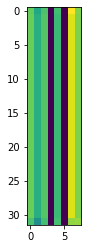

index:  349262
MAE:  0.010028678846424555
n_bunches       1212
bunch_index      824
bunch_number     591
Name: 8176353, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6940/instability_data/06940_Inst_B1H_Q7_20180718_05h01m14s.h5


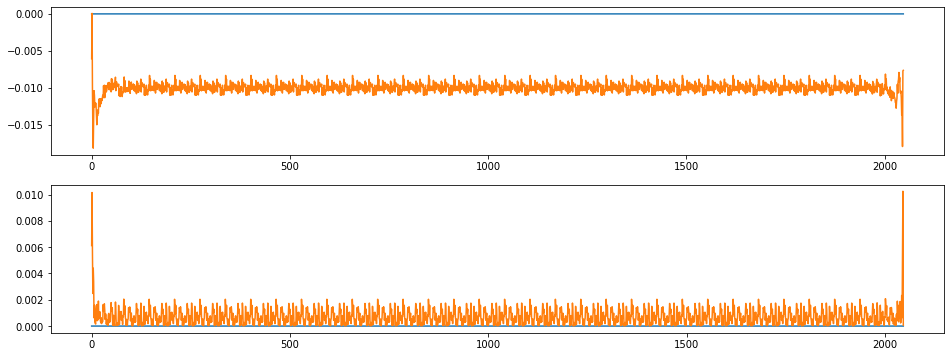

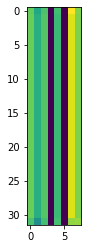

index:  47600
MAE:  0.010028678846424555
n_bunches       670
bunch_index     730
bunch_number    155
Name: 9822147, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7466/instability_data/07466_Inst_B1H_Q7_20181123_00h23m14s.h5


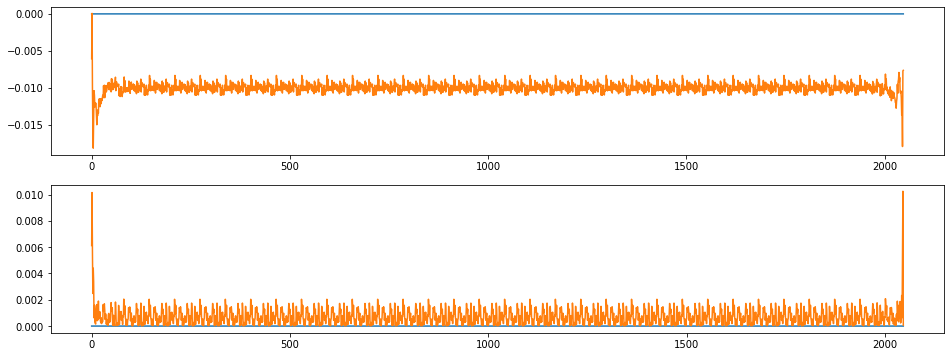

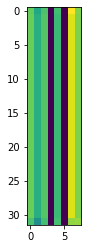

index:  135540
MAE:  0.010028678846424555
n_bunches        648
bunch_index     2602
bunch_number     485
Name: 8484554, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7448/instability_data/07448_Inst_B1H_Q7_20181116_08h29m15s.h5


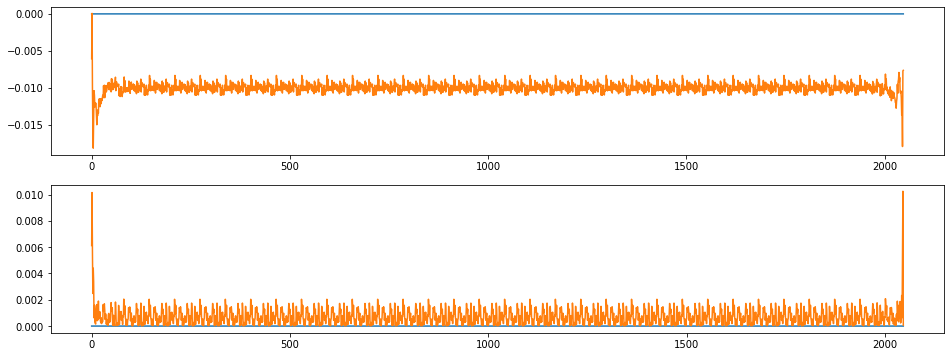

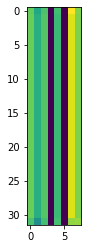

index:  65764
MAE:  0.010028678846424555
n_bunches       1868
bunch_index     1540
bunch_number     835
Name: 8366492, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6362/instability_data/06362_Inst_B1H_Q7_20171105_13h51m14s.h5


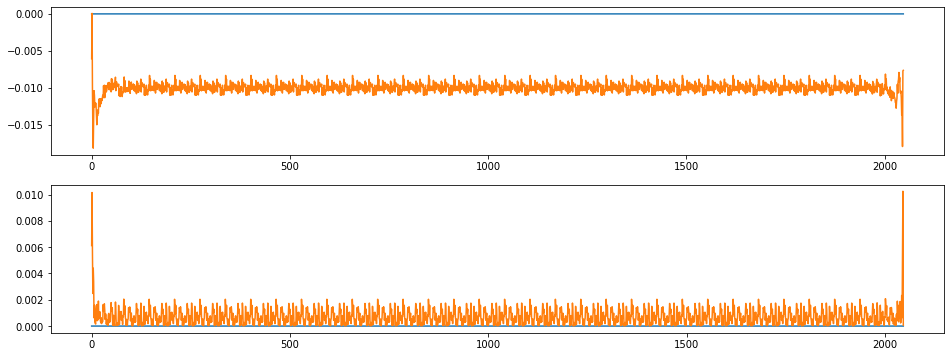

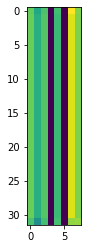

index:  290497
MAE:  0.010028678846424555
n_bunches       2556
bunch_index     1353
bunch_number     992
Name: 4452849, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7037/instability_data/07037_Inst_B1H_Q7_20180808_03h44m14s.h5


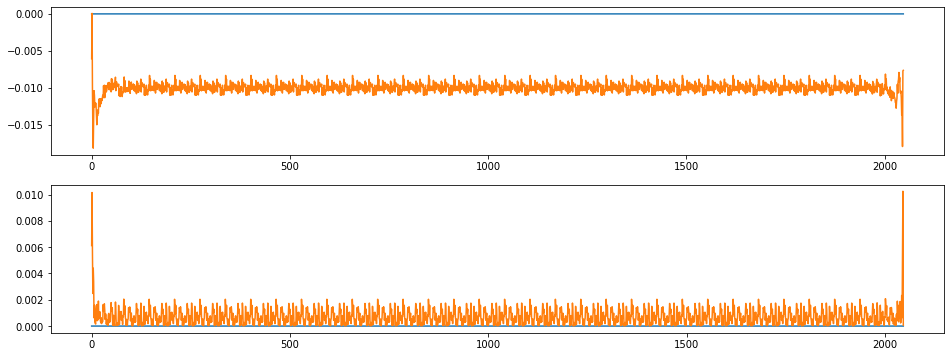

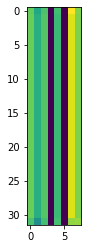

index:  42696
MAE:  0.010028678846424555
n_bunches       733
bunch_index     718
bunch_number    152
Name: 7545570, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7487/instability_data/07487_Inst_B1H_Q7_20181201_02h04m15s.h5


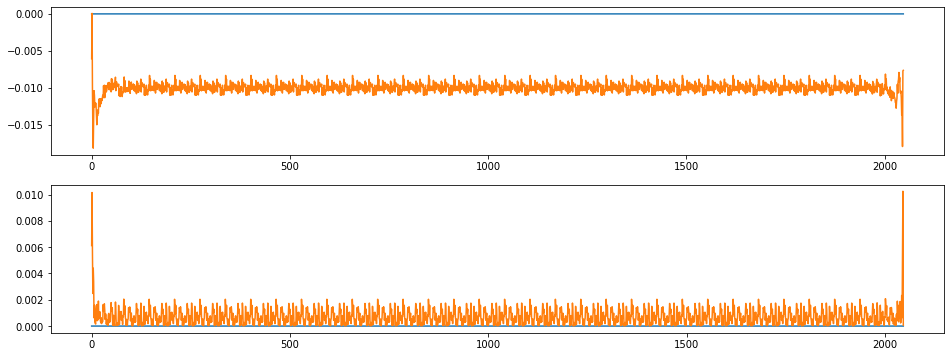

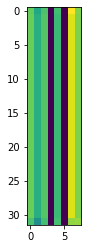

In [36]:
for i in range(1, 11):
    left_most = -i
    left_most_index = max_MAE_indices[left_most]
    
    encoding_output = encoding_model(train_dataset[max_MAE_indices[left_most]][None, :])

    print('index: ', left_most_index)
    print("MAE: ", MAE_train[left_most_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[left_most_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])


    true_signal = train_dataset[left_most_index].squeeze()
    pred_signal = train_pred[left_most_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()
    plt.imshow(np.array(encoding_output).squeeze())
    plt.show()

# Latent space encoding of anomalous signals

index:  206216
MAE:  1.103831116904872
n_bunches       2556
bunch_index     3290
bunch_number    2447
Name: 10458146, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6919/instability_data/06919_Inst_B1H_Q7_20180713_15h48m14s.h5


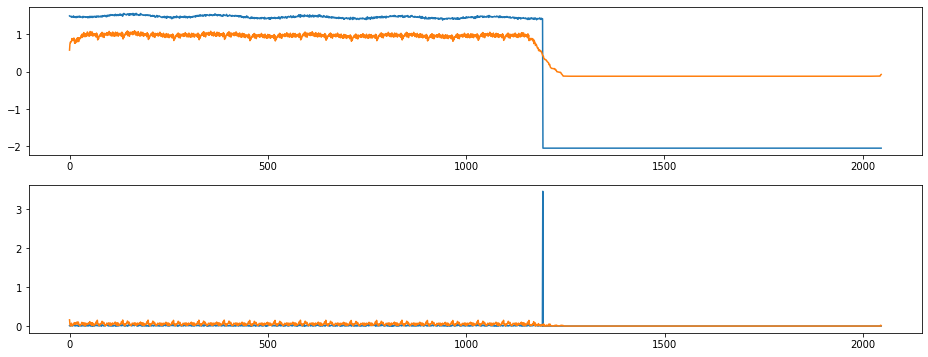

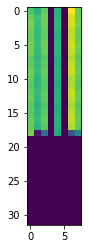

index:  190124
MAE:  0.8267367942707557
n_bunches       540
bunch_index     604
bunch_number    274
Name: 8385364, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7356/instability_data/07356_Inst_B1H_Q7_20181025_23h14m10s.h5


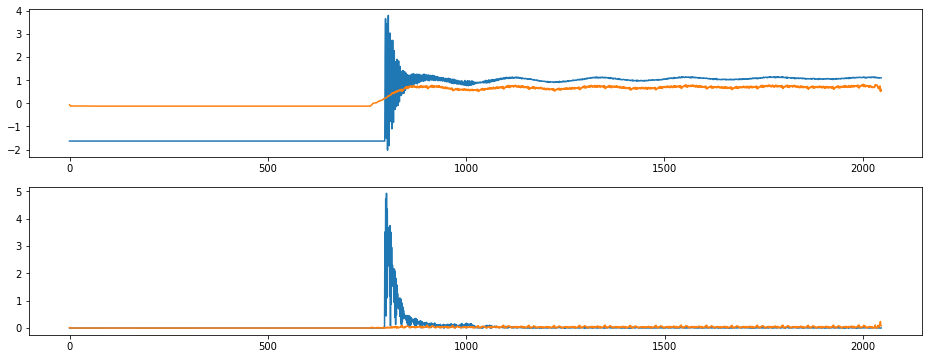

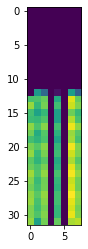

index:  29305
MAE:  0.8222281838854322
n_bunches        180
bunch_index     1653
bunch_number     101
Name: 6135380, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7361/instability_data/07361_Inst_B1H_Q7_20181026_15h02m25s.h5


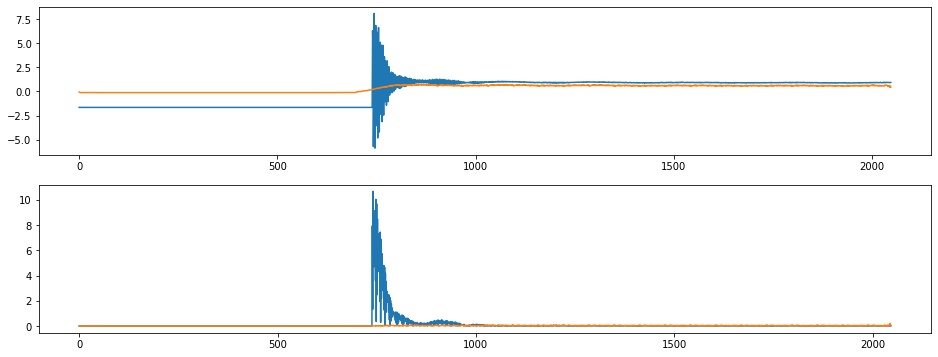

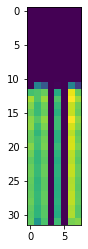

index:  365814
MAE:  0.791390090326662
n_bunches       265
bunch_index     478
bunch_number    144
Name: 6425847, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6618/instability_data/06618_Inst_B1H_Q7_20180428_03h54m13s.h5


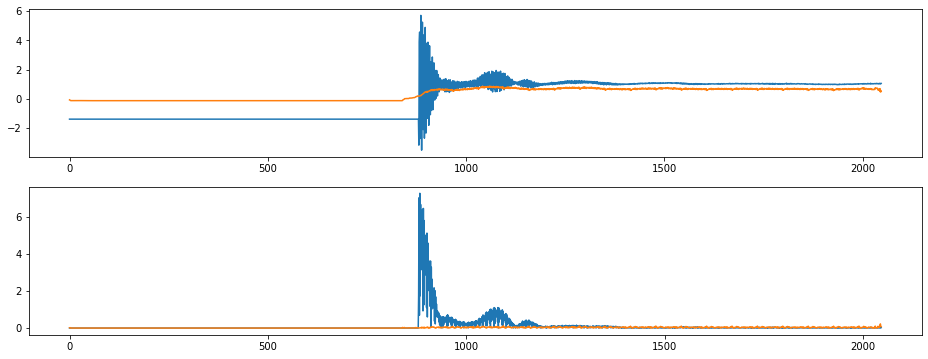

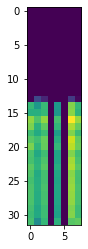

index:  78795
MAE:  0.7289054983651841
n_bunches       1004
bunch_index      966
bunch_number     519
Name: 4869340, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6341/instability_data/06341_Inst_B1H_Q7_20171028_00h07m49s.h5


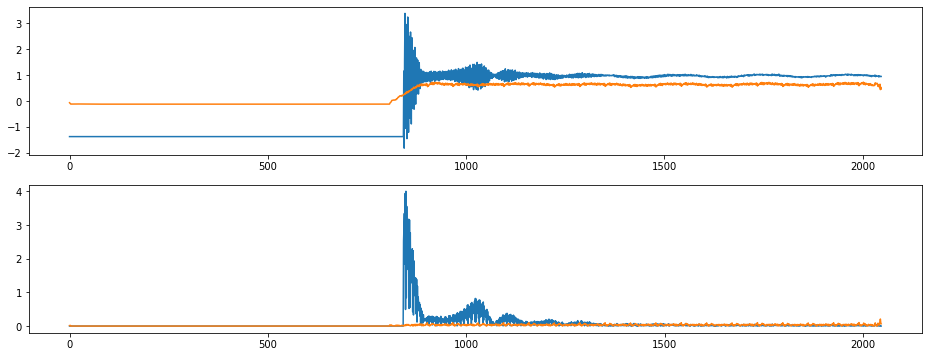

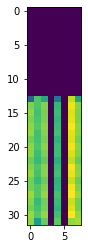

index:  149206
MAE:  0.7281070379986369
n_bunches       1887
bunch_index     1153
bunch_number     647
Name: 7696243, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6629/instability_data/06629_Inst_B1H_Q7_20180501_12h24m14s.h5


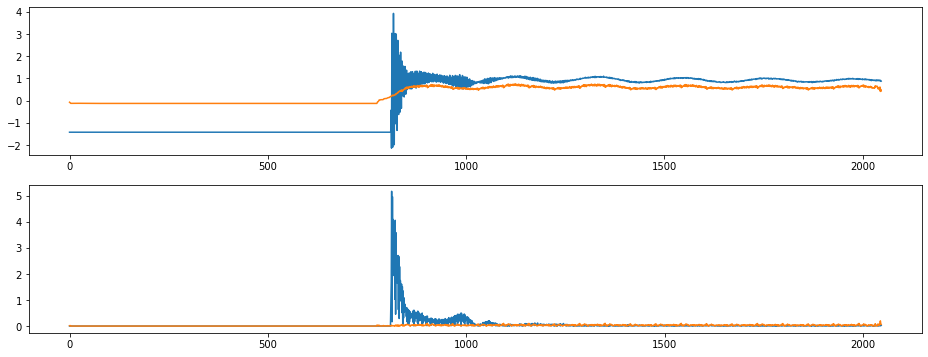

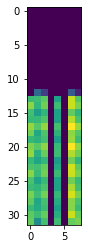

index:  406795
MAE:  0.7214782387059924
n_bunches       1452
bunch_index     3068
bunch_number    1307
Name: 3089590, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6890/instability_data/06890_Inst_B1H_Q7_20180705_22h44m14s.h5


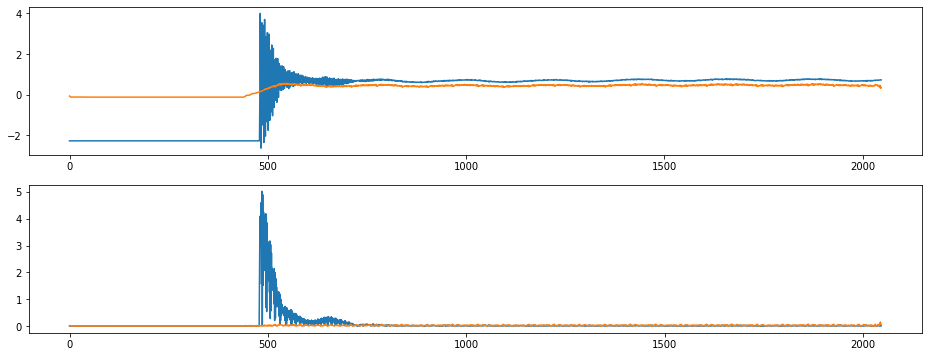

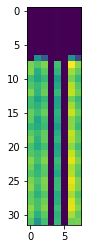

index:  326153
MAE:  0.6911518848472659
n_bunches       428
bunch_index     137
bunch_number     57
Name: 7519487, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6442/instability_data/06442_Inst_B1H_Q7_20171201_00h02m07s.h5


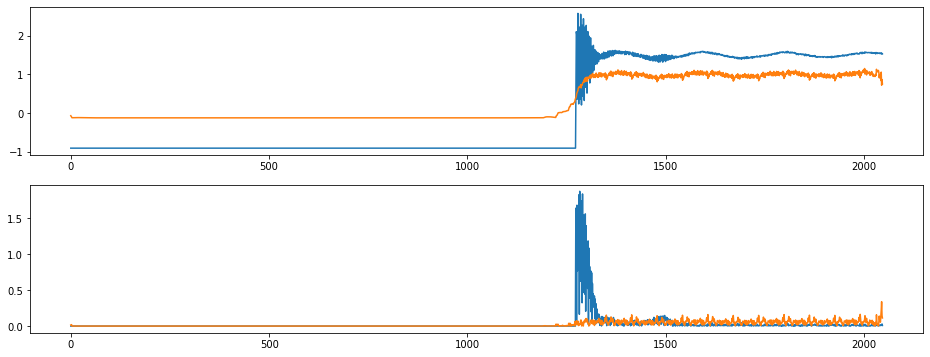

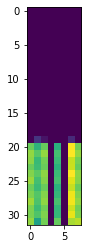

index:  350979
MAE:  0.6790853122018424
n_bunches       361
bunch_index     203
bunch_number     39
Name: 9131435, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7036/instability_data/07036_Inst_B1H_Q7_20180807_20h32m53s.h5


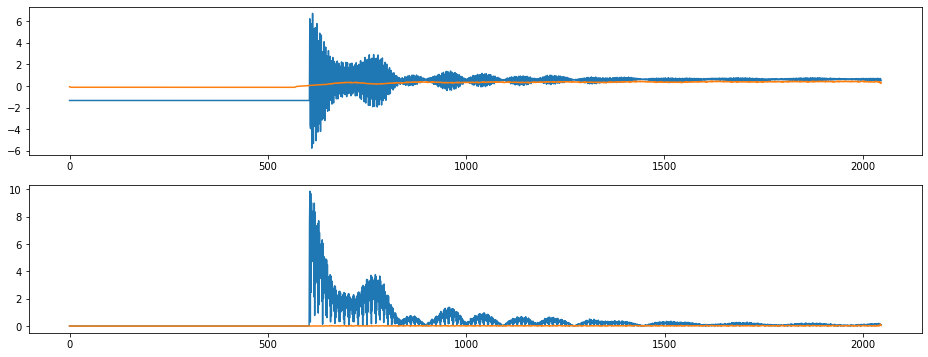

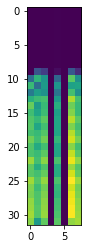

index:  150002
MAE:  0.6714419514849932
n_bunches       1868
bunch_index     1801
bunch_number     963
Name: 9138831, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6364/instability_data/06364_Inst_B1H_Q7_20171106_03h13m17s.h5


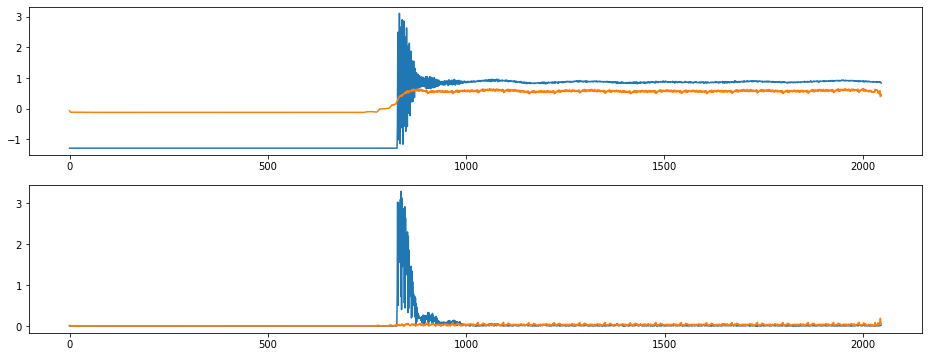

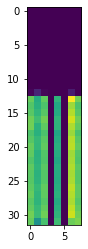

index:  103571
MAE:  0.662062803117413
n_bunches       924
bunch_index     272
bunch_number    178
Name: 10147119, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7033/instability_data/07033_Inst_B1H_Q7_20180807_03h59m19s.h5


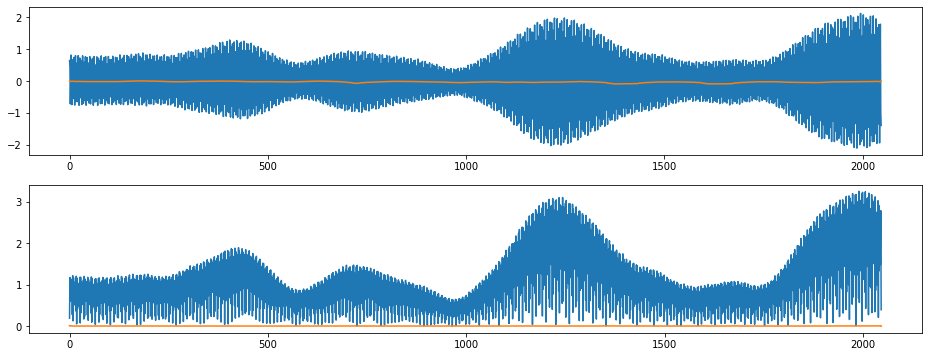

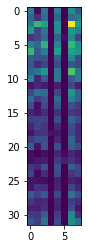

index:  113308
MAE:  0.652283001820493
n_bunches       2460
bunch_index      834
bunch_number     595
Name: 1559591, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6860/instability_data/06860_Inst_B1H_Q7_20180628_17h38m59s.h5


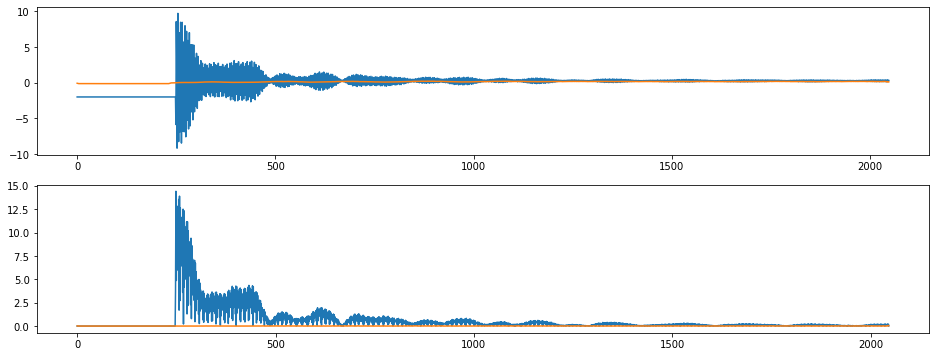

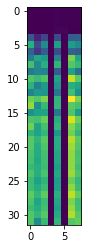

index:  199359
MAE:  0.6508316806511785
n_bunches       652
bunch_index     825
bunch_number    428
Name: 8681950, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6360/instability_data/06360_Inst_B1H_Q7_20171103_13h14m08s.h5


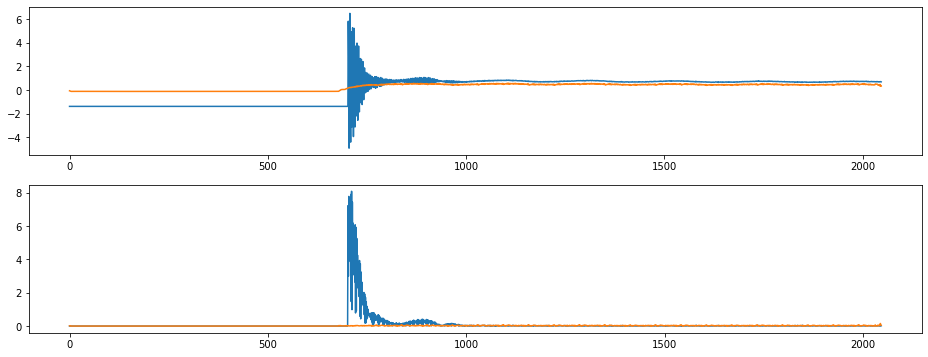

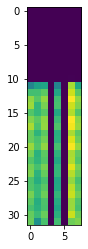

index:  214202
MAE:  0.6282899304895109
n_bunches       1227
bunch_index      530
bunch_number     249
Name: 1772365, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6690/instability_data/06690_Inst_B1H_Q7_20180516_09h14m14s.h5


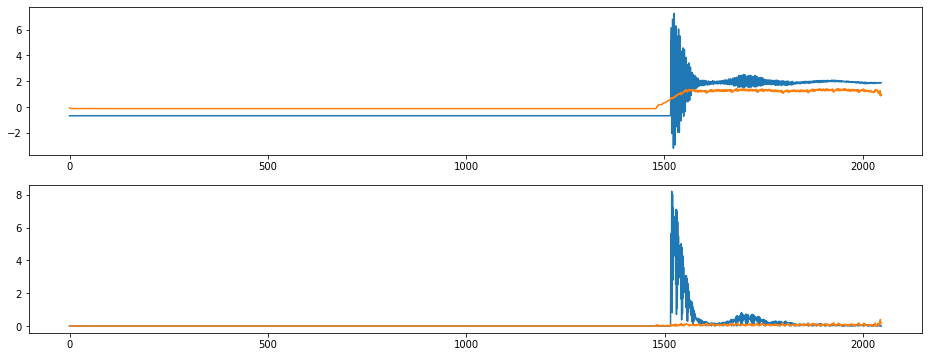

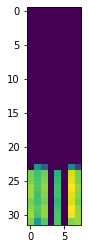

index:  331638
MAE:  0.6278571035732456
n_bunches        733
bunch_index     1903
bunch_number     400
Name: 8042049, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7487/instability_data/07487_Inst_B1H_Q7_20181201_01h12m15s.h5


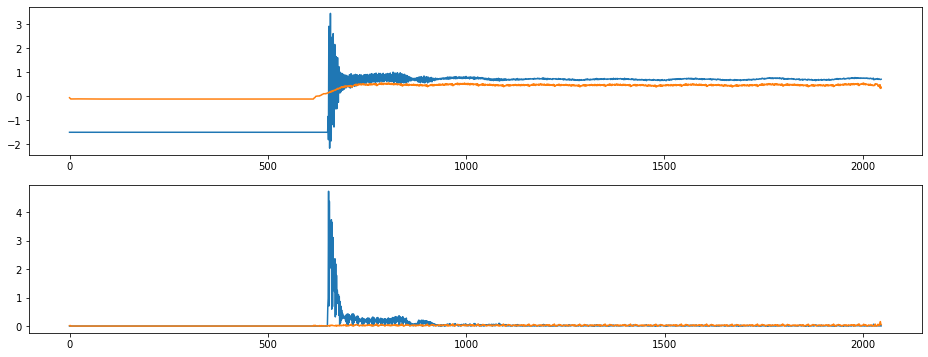

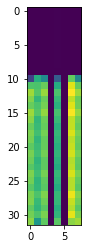

index:  44050
MAE:  0.6198713490020453
n_bunches       1887
bunch_index     2987
bunch_number    1648
Name: 10157846, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6693/instability_data/06693_Inst_B1H_Q7_20180517_06h44m13s.h5


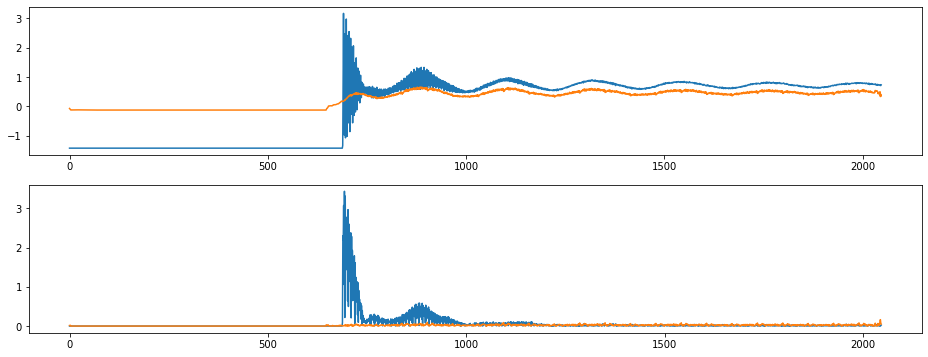

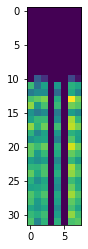

index:  186405
MAE:  0.600752833067232
n_bunches       2556
bunch_index     2233
bunch_number    1638
Name: 6324133, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6654/instability_data/06654_Inst_B1H_Q7_20180508_01h11m13s.h5


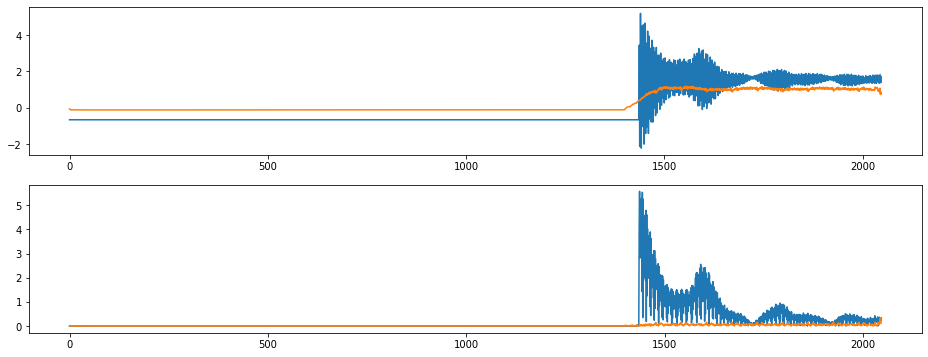

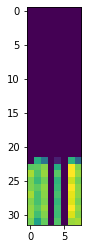

index:  344229
MAE:  0.5680500679035959
n_bunches       1452
bunch_index      548
bunch_number     221
Name: 3109432, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6890/instability_data/06890_Inst_B1H_Q7_20180705_14h55m15s.h5


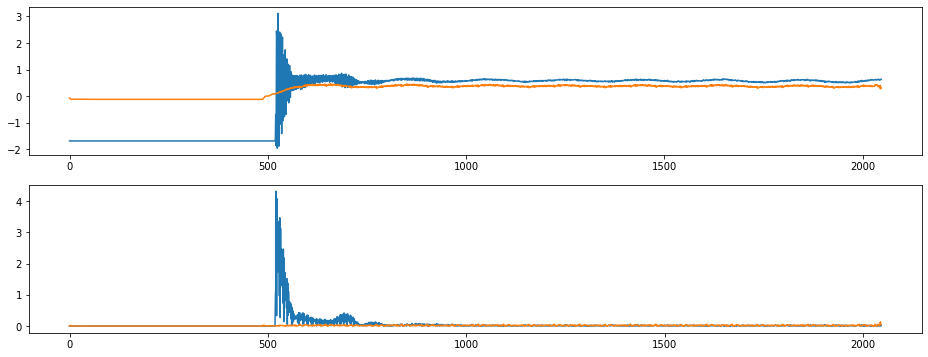

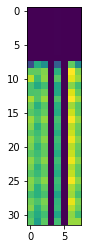

index:  237216
MAE:  0.5576742434503212
n_bunches        734
bunch_index     1022
bunch_number     204
Name: 9399237, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6881/instability_data/06881_Inst_B1H_Q7_20180703_07h01m49s.h5


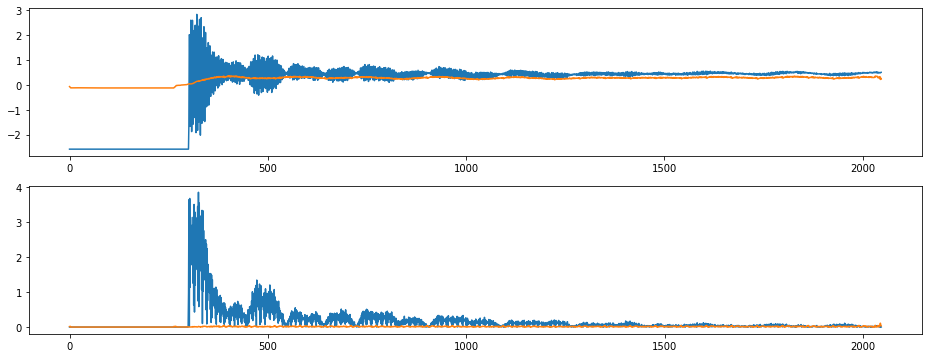

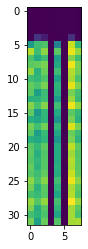

index:  126055
MAE:  0.5453832138654033
n_bunches       24
bunch_index     48
bunch_number    11
Name: 1312686, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6680/instability_data/06680_Inst_B1H_Q7_20180514_06h03m15s.h5


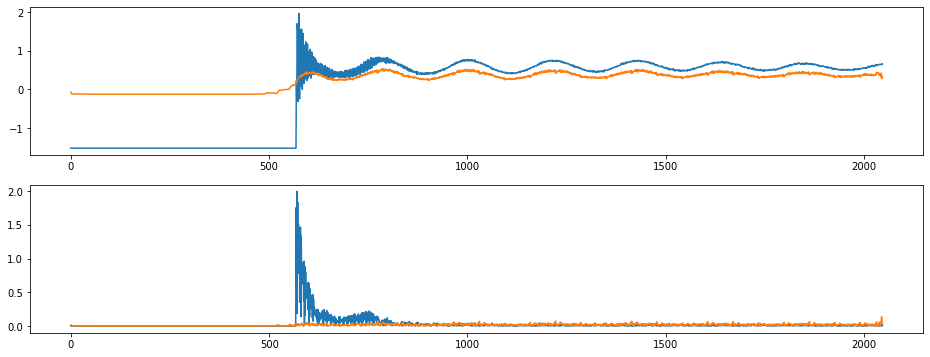

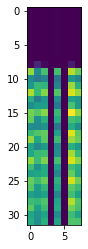

index:  93634
MAE:  0.5337039825370775
n_bunches        648
bunch_index     2656
bunch_number     497
Name: 7454650, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7444/instability_data/07444_Inst_B1H_Q7_20181115_08h09m15s.h5


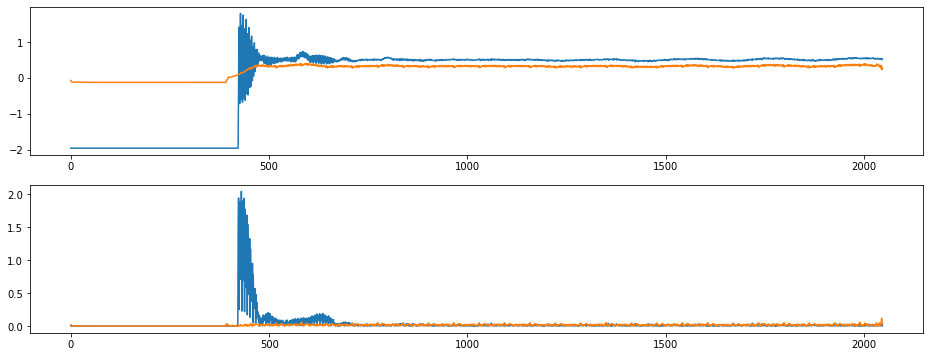

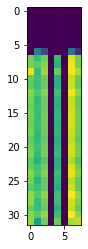

index:  30324
MAE:  0.5242000845703815
n_bunches       1868
bunch_index     1936
bunch_number    1032
Name: 9197797, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6275/instability_data/06275_Inst_B1H_Q7_20171006_08h54m55s.h5


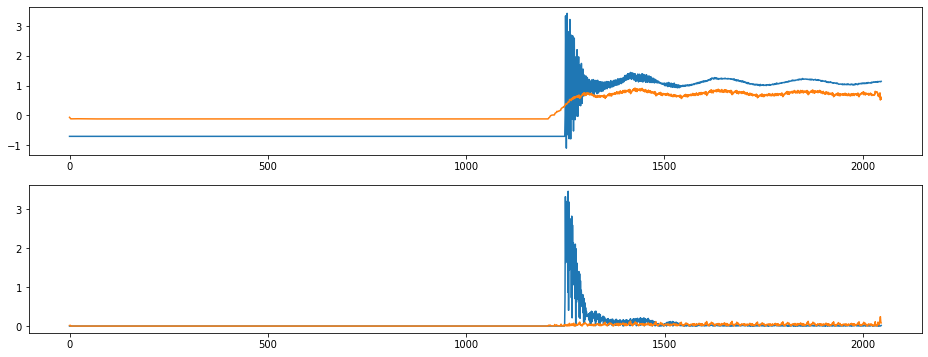

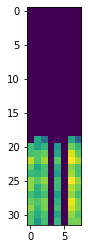

index:  343923
MAE:  0.5235589334302575
n_bunches       2556
bunch_index      258
bunch_number     164
Name: 9622956, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7270/instability_data/07270_Inst_B1H_Q7_20181009_03h22m13s.h5


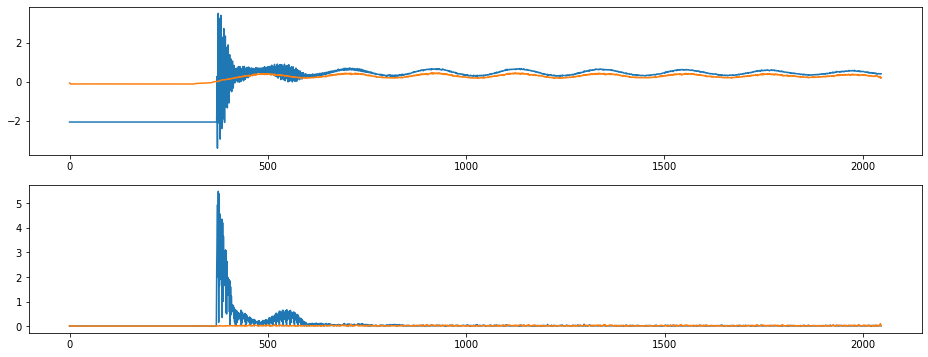

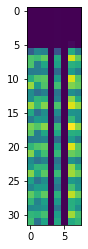

index:  27367
MAE:  0.5216391748279092
n_bunches       172
bunch_index      57
bunch_number     20
Name: 11554468, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6284/instability_data/06284_Inst_B1H_Q7_20171008_16h33m44s.h5


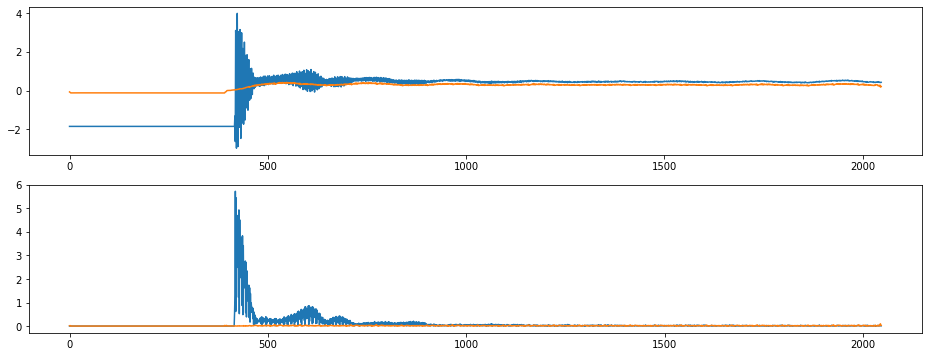

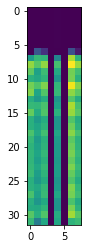

index:  58346
MAE:  0.5196294691045431
n_bunches       1956
bunch_index      784
bunch_number     625
Name: 3448151, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6602/instability_data/06602_Inst_B1H_Q7_20180423_18h34m15s.h5


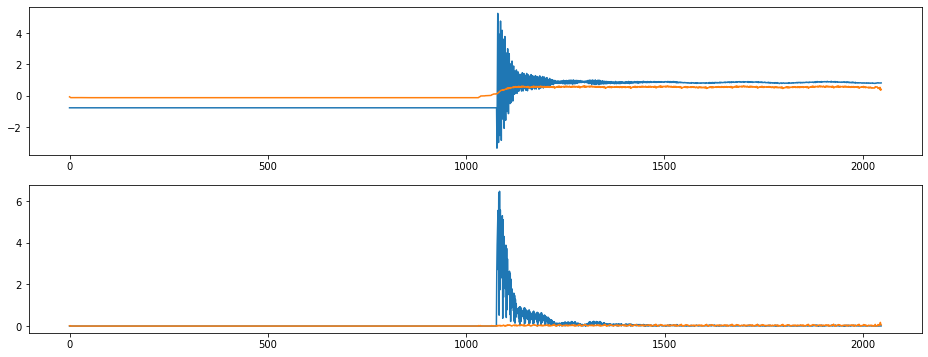

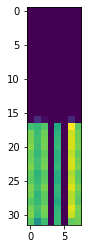

index:  319498
MAE:  0.5020705653390378
n_bunches       396
bunch_index     390
bunch_number    258
Name: 606152, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6775/instability_data/06775_Inst_B1H_Q7_20180611_15h14m42s.h5


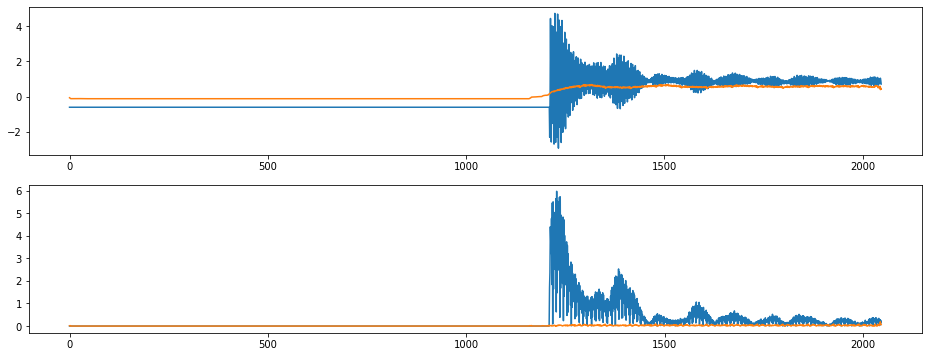

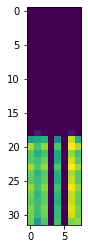

index:  312679
MAE:  0.5000395642224285
n_bunches       2556
bunch_index     2229
bunch_number    1634
Name: 6283160, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6759/instability_data/06759_Inst_B1H_Q7_20180605_12h47m24s.h5


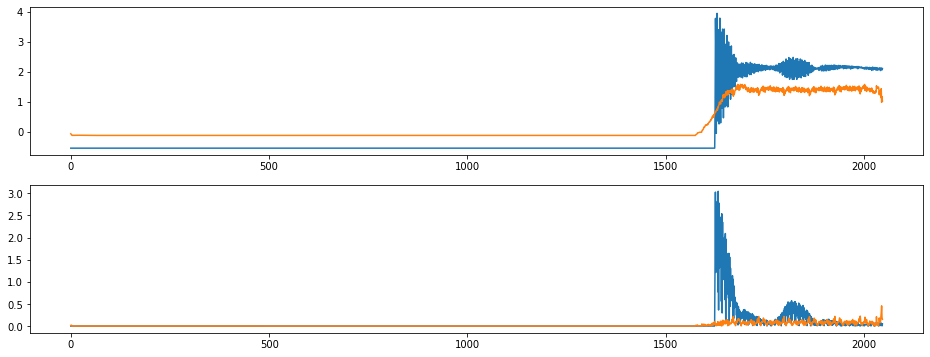

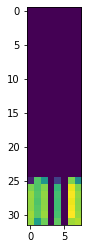

index:  1580
MAE:  0.4967028127429667
n_bunches       2556
bunch_index     1205
bunch_number     882
Name: 5249315, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7135/instability_data/07135_Inst_B1H_Q7_20180907_23h16m14s.h5


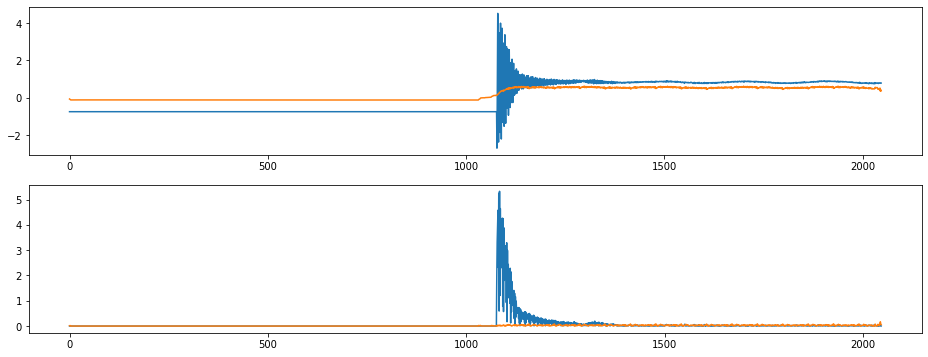

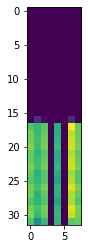

index:  105348
MAE:  0.49594691911864175
n_bunches       2556
bunch_index     3235
bunch_number    2404
Name: 10113830, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6666/instability_data/06666_Inst_B1H_Q7_20180510_23h05m15s.h5


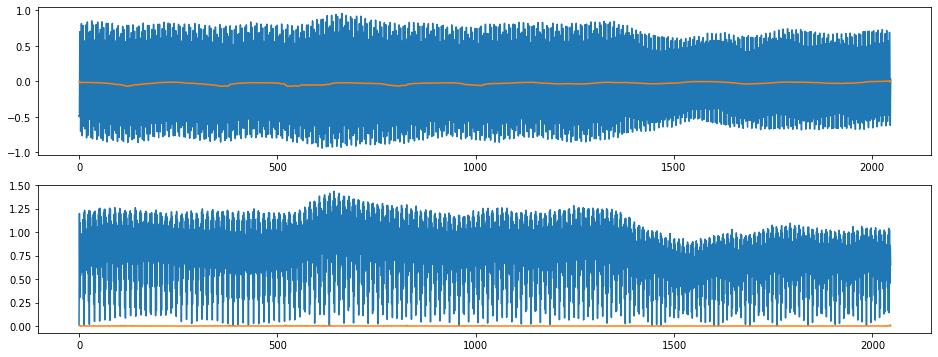

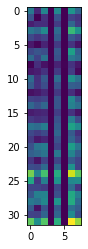

index:  311632
MAE:  0.4871392100340827
n_bunches       1358
bunch_index     1585
bunch_number     666
Name: 9835917, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6239/instability_data/06239_Inst_B1H_Q7_20170924_05h21m14s.h5


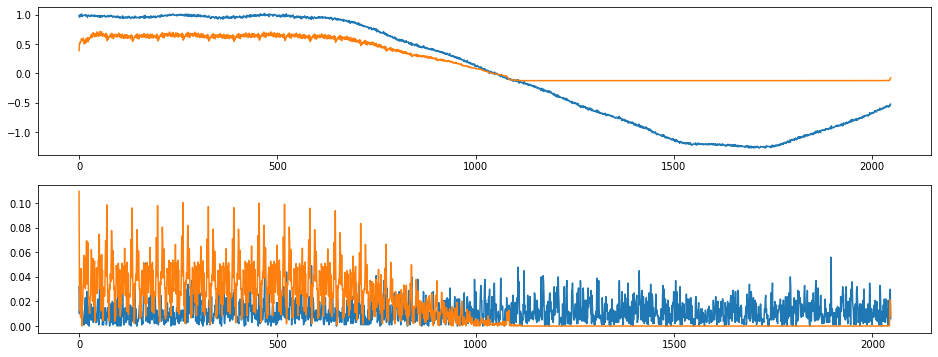

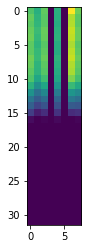

index:  152050
MAE:  0.48576800861070313
n_bunches       1068
bunch_index      464
bunch_number     325
Name: 230174, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6924/instability_data/06924_Inst_B1H_Q7_20180715_08h18m43s.h5


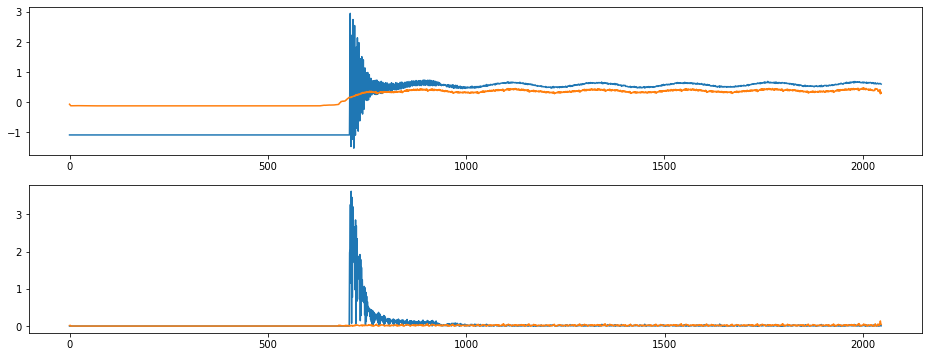

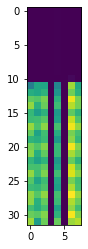

index:  345858
MAE:  0.48378037896175824
n_bunches       2556
bunch_index     1717
bunch_number    1262
Name: 10971254, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7052/instability_data/07052_Inst_B1H_Q7_20180813_18h44m14s.h5


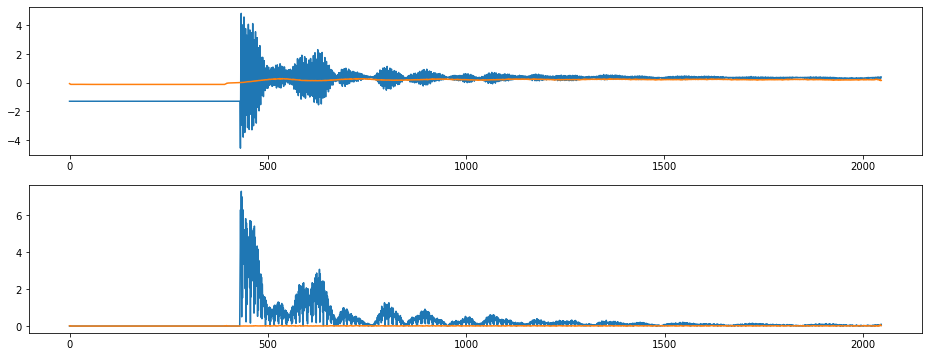

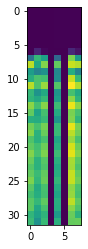

index:  12030
MAE:  0.4825866072639729
n_bunches       746
bunch_index     252
bunch_number     81
Name: 5580607, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6617/instability_data/06617_Inst_B1H_Q7_20180427_15h32m14s.h5


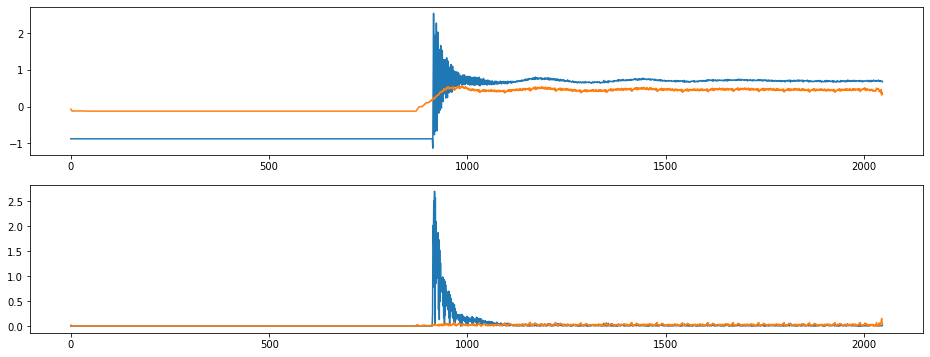

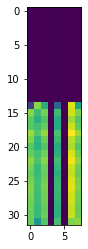

index:  400134
MAE:  0.48120340913143533
n_bunches       796
bunch_index     432
bunch_number    229
Name: 7121399, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6252/instability_data/06252_Inst_B1H_Q7_20170927_21h28m34s.h5


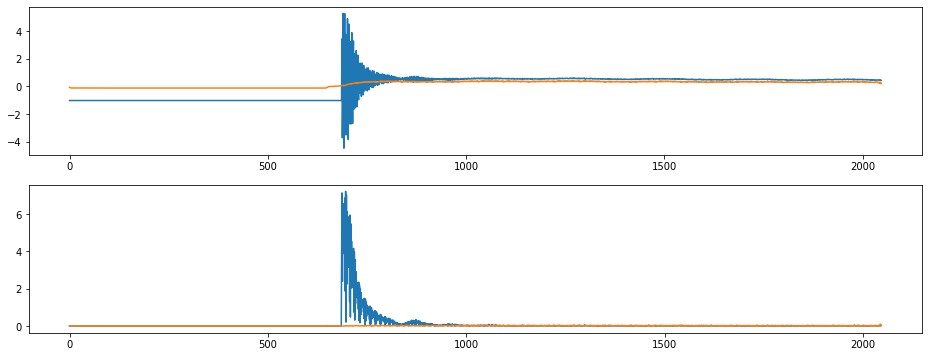

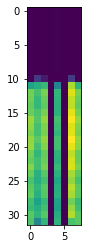

index:  66510
MAE:  0.47291696628673535
n_bunches       2556
bunch_index     1119
bunch_number     810
Name: 11304798, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7058/instability_data/07058_Inst_B1H_Q7_20180817_18h33m15s.h5


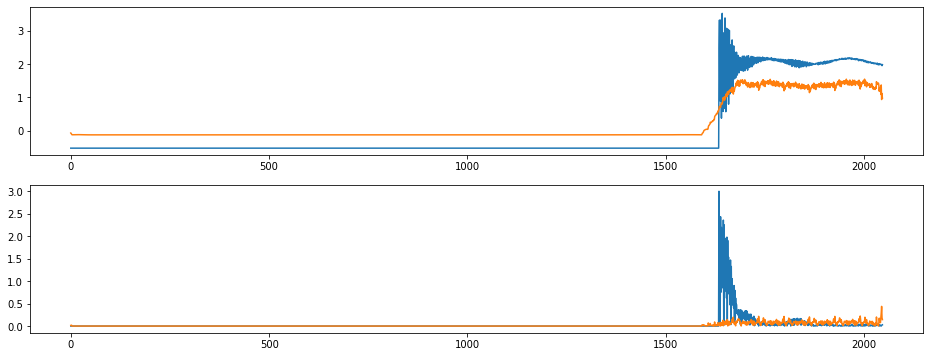

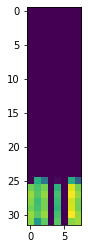

index:  213862
MAE:  0.4710458926504543
n_bunches        156
bunch_index     2311
bunch_number      71
Name: 11605015, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6200/instability_data/06200_Inst_B1H_Q7_20170914_23h39m15s.h5


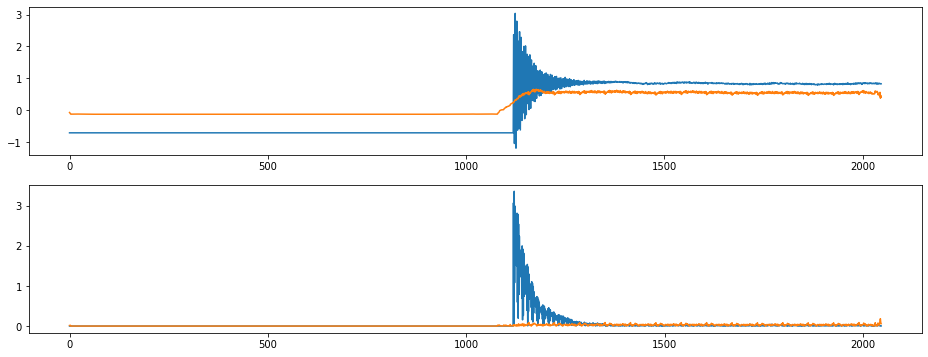

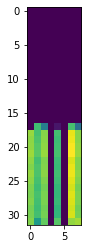

index:  99430
MAE:  0.47058913674005676
n_bunches       396
bunch_index     389
bunch_number    257
Name: 9445516, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7061/instability_data/07061_Inst_B1H_Q7_20180817_22h07m44s.h5


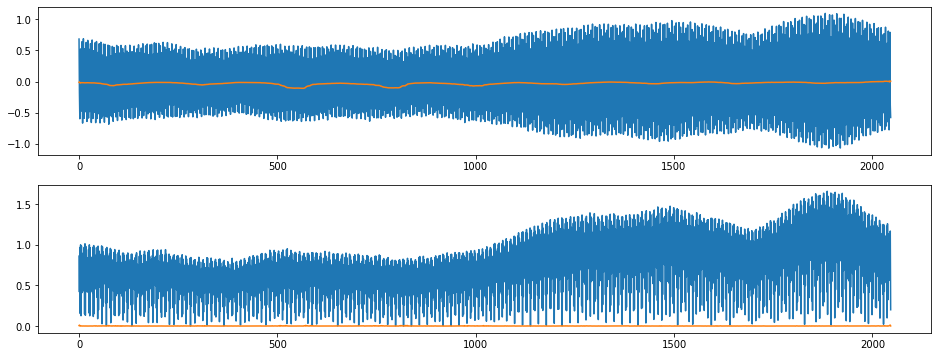

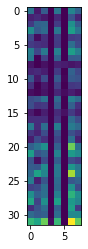

index:  396617
MAE:  0.44790459249140974
n_bunches       1452
bunch_index     1634
bunch_number     689
Name: 88083, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6890/instability_data/06890_Inst_B1H_Q7_20180705_16h53m14s.h5


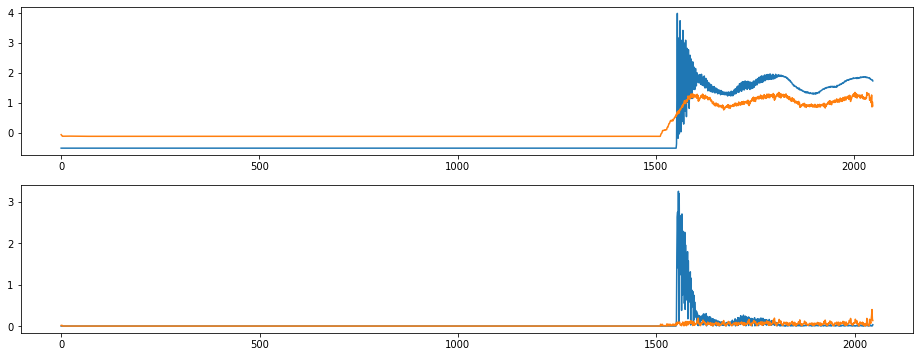

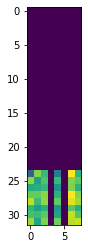

index:  77074
MAE:  0.44584236125253307
n_bunches       144
bunch_index     101
bunch_number     31
Name: 2458825, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7349/instability_data/07349_Inst_B1H_Q7_20181025_14h26m59s.h5


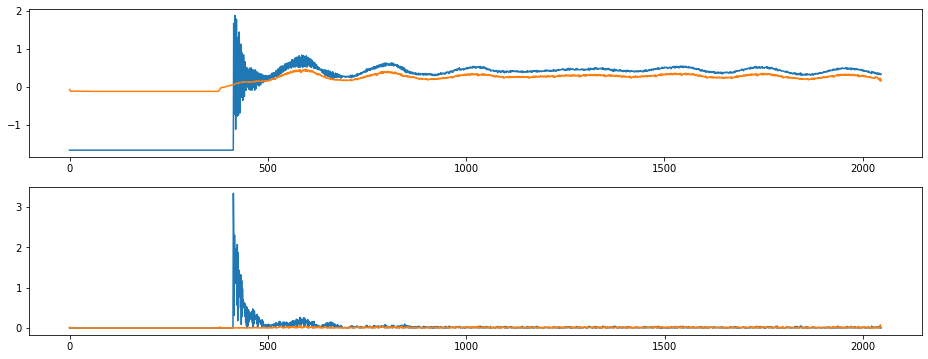

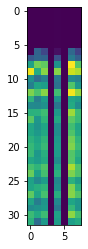

index:  316576
MAE:  0.44544240367290244
n_bunches       2556
bunch_index     3184
bunch_number    2372
Name: 2637480, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6923/instability_data/06923_Inst_B1H_Q7_20180714_21h30m14s.h5


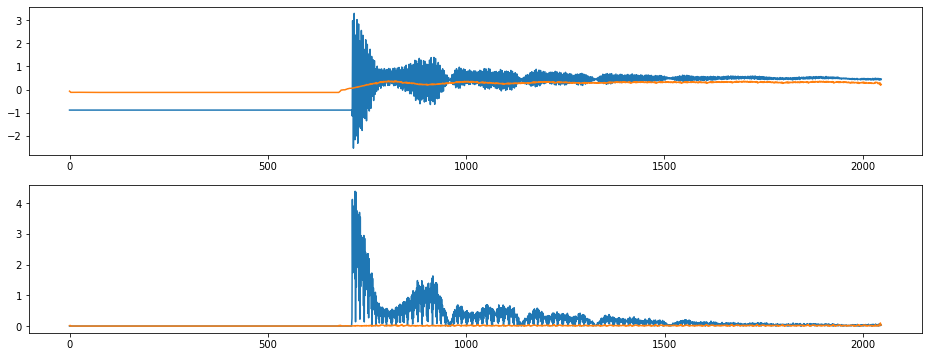

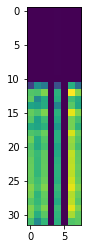

index:  198888
MAE:  0.44400658858809683
n_bunches       1868
bunch_index     3093
bunch_number    1660
Name: 6500879, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6351/instability_data/06351_Inst_B1H_Q7_20171031_16h59m14s.h5


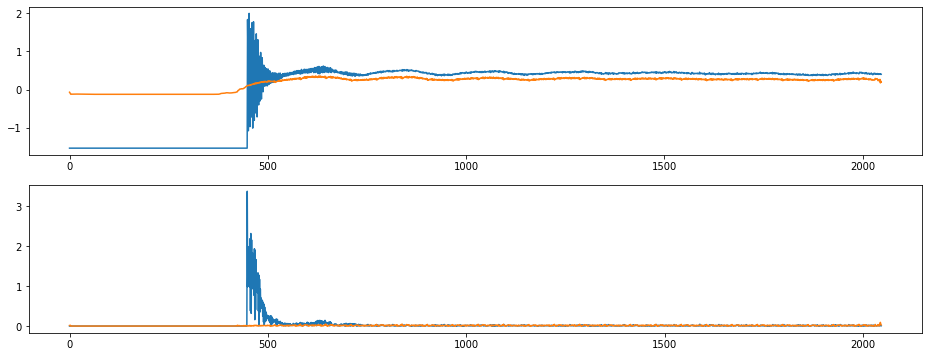

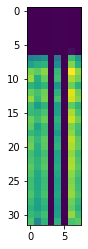

index:  6935
MAE:  0.4320859130339386
n_bunches       1227
bunch_index      529
bunch_number     248
Name: 10722670, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6690/instability_data/06690_Inst_B1H_Q7_20180516_04h59m14s.h5


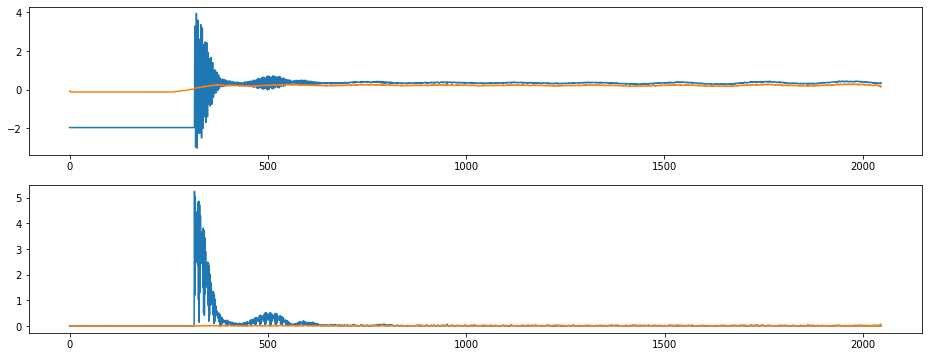

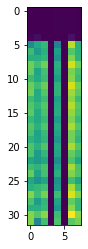

index:  31081
MAE:  0.4161951713140261
n_bunches       502
bunch_index     109
bunch_number     19
Name: 7943291, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7480/instability_data/07480_Inst_B1H_Q7_20181127_23h04m01s.h5


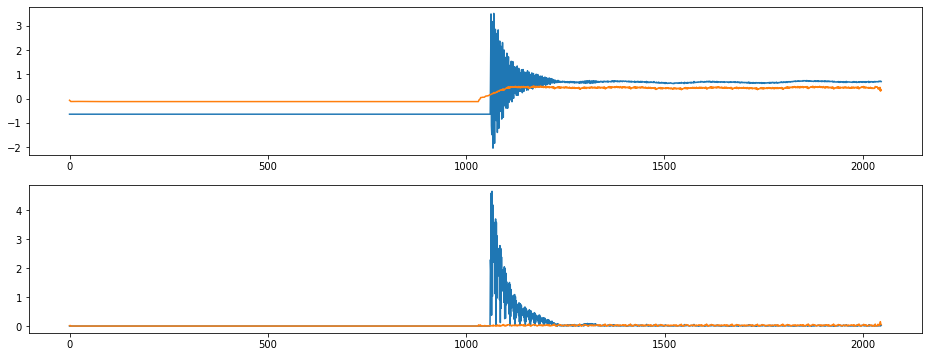

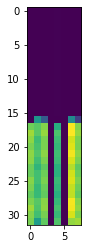

index:  331605
MAE:  0.4154087607077217
n_bunches       2556
bunch_index     2009
bunch_number    1478
Name: 5309157, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6919/instability_data/06919_Inst_B1H_Q7_20180713_23h10m14s.h5


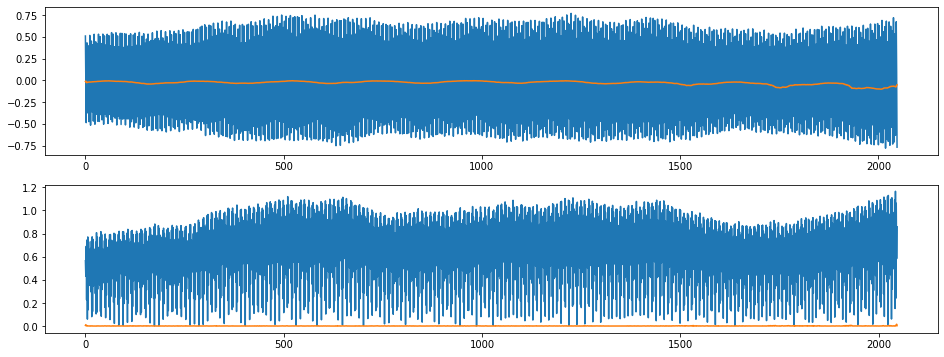

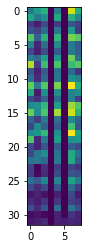

index:  161153
MAE:  0.41415311545481015
n_bunches        492
bunch_index     1692
bunch_number     428
Name: 4887876, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6805/instability_data/06805_Inst_B1H_Q7_20180616_02h03m14s.h5


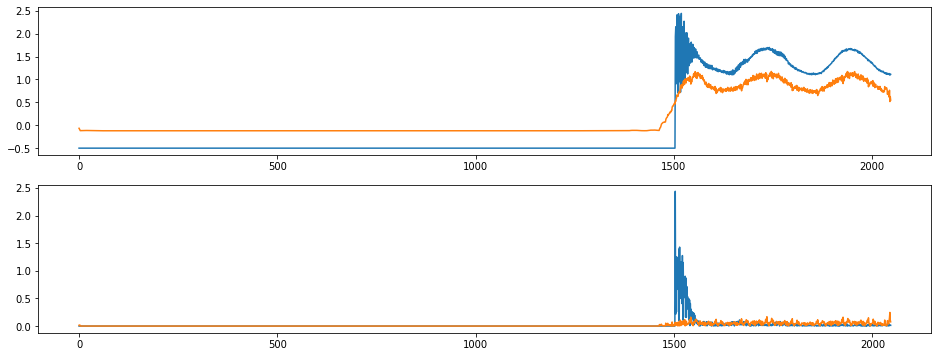

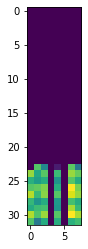

index:  100755
MAE:  0.4065997201645978
n_bunches       2556
bunch_index      361
bunch_number     241
Name: 4631919, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6663/instability_data/06663_Inst_B1H_Q7_20180510_14h43m15s.h5


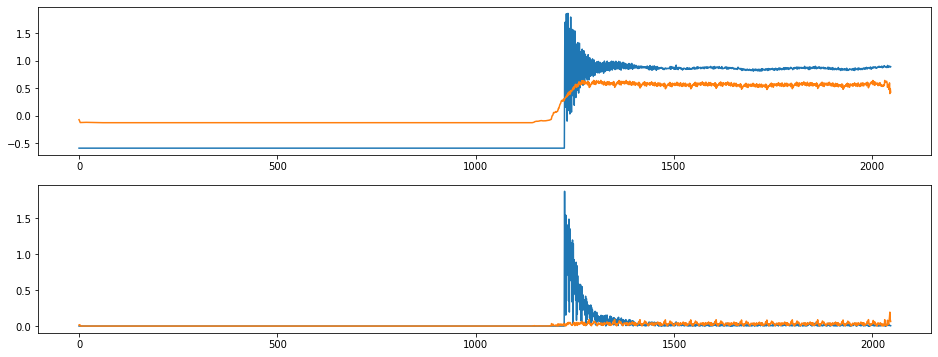

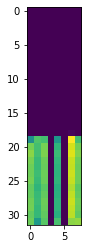

index:  68025
MAE:  0.4035043685109786
n_bunches       1868
bunch_index     1358
bunch_number     734
Name: 292825, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6349/instability_data/06349_Inst_B1H_Q7_20171031_07h50m14s.h5


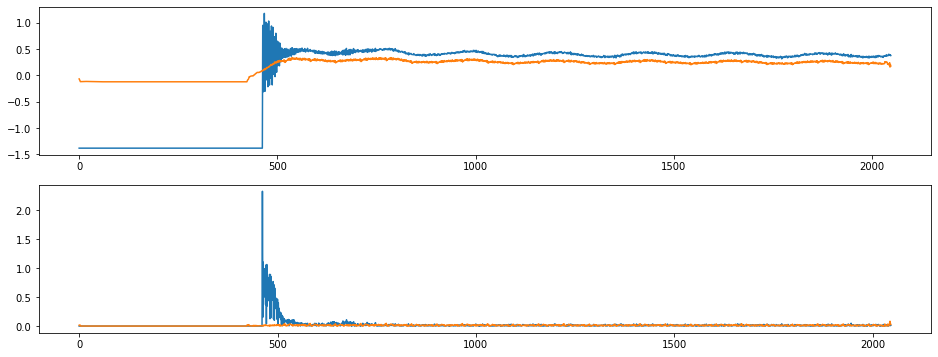

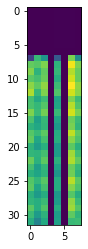

index:  334706
MAE:  0.40058058885381387
n_bunches       1868
bunch_index     1576
bunch_number     856
Name: 8409564, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6343/instability_data/06343_Inst_B1H_Q7_20171028_12h04m14s.h5


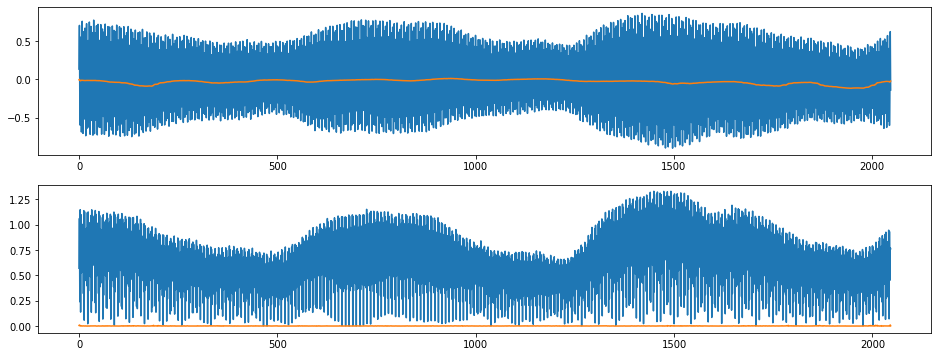

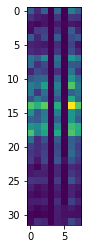

index:  96198
MAE:  0.39479647763924275
n_bunches       1164
bunch_index     1185
bunch_number     843
Name: 487053, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6606/instability_data/06606_Inst_B1H_Q7_20180424_01h55m08s.h5


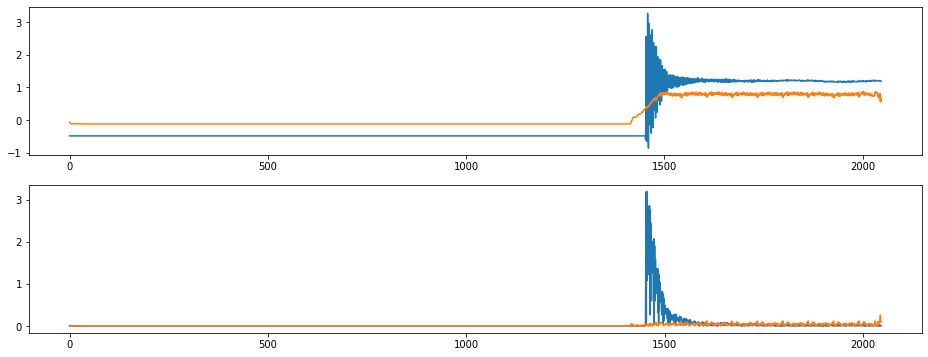

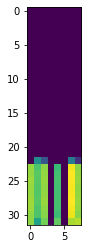

index:  48377
MAE:  0.39293727633516484
n_bunches       2556
bunch_index     2408
bunch_number    1787
Name: 6351332, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7139/instability_data/07139_Inst_B1H_Q7_20180908_19h18m39s.h5


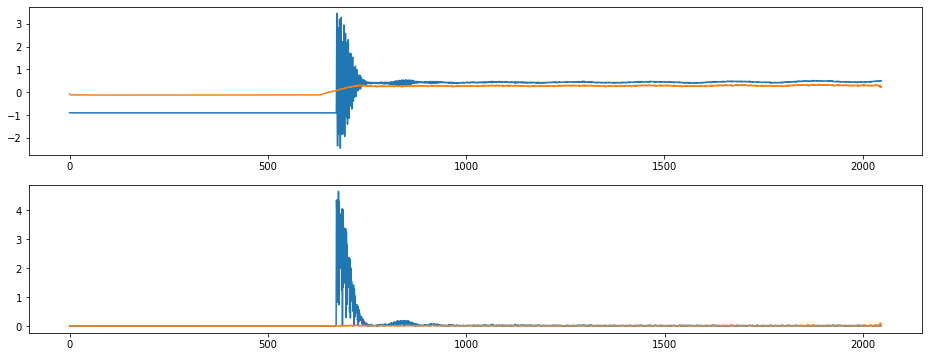

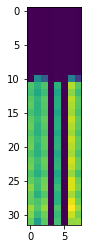

In [37]:
for i in range(50):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]
    
    encoding_output = encoding_model(train_dataset[anomalous_index][None, :])

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()
    plt.imshow(np.array(encoding_output).squeeze())
    plt.show()